# A Data-Filled Day with the Mouse

## Introduction and Motivation

Disney is a gold mine of data. Between the Parks, Movies, Television Networks, and other Entertainment subsidiaries, there is an unlimited amount of data sources for aspiring Data Scientists to explore. With so many opportunities, I wanted to take the time to explore one avenue and show how even a simple project could prove beneficial to such a large corporation.


Disney Parks Blog (http://disneyparks.disney.go.com/blog/) is Disney's primary outlet for announcements and news about  Disneyland Resort, Walt Disney World, and Disney Cruise Lines. The Disney Parks Blog, like most blogs on the internet, allows authors (bloggers) to write about a topic of interest - in this case, Disney related subjects. Once a Blog Post is submitted, anyone with access to the World Wide Web can view and add comments to the Blog Post.


Why would anyone be interested in blog data? Imagine a Disney marketing team looking to capitalize on park audiences. Which parks should the team focus on to maximize return? One option is to compare park popularity by ticket sales. Another would be to look at the parks with the most facebook likes or commenters on the blog. What about a Disney advertising group trying to determine when to schedule Disney ads to an online audience? Just by exploring some blog trends, we can predict the most likely time of the day Disney enthusiasts will be online. These are just a few of the ways that data analysis can be useful to Disney Corporation.


Ultimately, I'm doing this mini-project to improve my skillset and explore a data set that I've never seen previously. However, like many others, Disney was a large part of my childhood. The mere fact that this small project can be useful to Disney only bolsters my enthusiasm for data.


Before I begin, it is important to mention that this is an exploration project - that is to say, there is no clearly defined question that needs to be answered. As I often find with data-driven projects, the amount of guidance is minimal. It is therefore up to the Data Scientist to explore and do his diligence to find questions worthwhile of answering.

## Layout

1. Introduction and Motivation
   - An introduction to the project and a motivation for running the analysis.
2. Layout
   - "You are here"
3. Prerequisites
   - High level material, such as importing frequently used python packages and defining commonly used variables (I'm originally a Computer Scientist, so I do my best to avoid globals).
4. The Data
   - A brief introduction to the data.
5. Exploration
   - Graphs and summary data to help describe the data.
6. Cruising on the Rise
   - I take an in-depth look at Disney Cruise Lines.
7. Weekday vs. Weekend Posts
   - An analysis to see if posting on a weekday is advantageous.
8. Negative Comment Detection (Sentiment Analysis)
   - An attempt at sentiment analysis on blog post comments.
9. Appendix
   - Methods that aren't directly related to the analysis. Most code to clean / cache data.



## Prerequisites

In [1]:
import collections
import itertools
from datetime import datetime
import json
import os
import os.path
import pickle
from pprint import pprint
from random import shuffle
import re
import warnings

# Ignore future matplotlib warnings
warnings.filterwarnings("ignore", module="matplotlib")

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

import tensorflow as tf
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel 

# Matplotlib settings.
%matplotlib inline
plt.rcParams.update({'font.size': 18})

# Seaborn settings.
sns.set(rc={"figure.figsize": (14, 7)})
sns.set_palette(sns.color_palette("Blues_d"))

In [49]:
META = {
    # File paths for the data.
    'data': {
        'blog': {
            'path': 'data/blog'
        },
        'sentiments': {
            'filename': "data/sentiment/sentiments.json"
        },
        'comments_positive': {
            'filename': "data/sentiment/comments_positive.json"
        },
        'comments_negative': {
            'filename': "data/sentiment/comments-negative.json"
        },
        'cache': 'data/cache'
    },
    # Models.
    'model': {
        'sentiment': 'models/sentiment/sentiment-model.ckpt'
    },
    # Plotting info for matplotlib / seaborn
    'plots': {
        'palette': 'Blues_d',
        'width': 16,
        'height': 8,
    }
}

## The Data

### Acquisition

After browsing the web for a while, I determined that the blog was ideal because it is full of content and is freely available to the public.

As I do not have direct access to Disney's Data, I developed a spider (code that autonomously navigates the website) to slowly scrape all of the blog posts. Once all of the blog posts were available locally, the data was wrangled into a format that could be easily consumed.

**(Please note that as of early 2016, the disney blog has updated. Features, such as Facebook Likes, maybe be inconsistent with the data I obtained late 2015).**

### Wrangling

For the sake of brevity, it is not necessary to discuss how the data was obtained and cleaned. In the end, ~10,000 JSON files were available with content similar to the following:

In [3]:
def demo_json_file():
    """Demo the json file contents."""
    
    path = "2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival.json"
    filepath = "{0}/{1}".format(META['data']['blog']['path'], path)
    
    with open(filepath, 'r') as file:    
        pprint(json.load(file))

# Execute.
demo_json_file()

{'author': {'division': 'Disney Parks',
            'name': 'Thomas Smith',
            'role': 'Social Media Director'},
 'body': '    Sure, the Epcot International Food & Wine Festival has just '
         'begun but we’re not waiting to give you a taste of what’s to come in '
         'October. The Disney Parks Blog has an early peek at a few of the '
         'more than 250 amazing chefs scheduled to appear during the six-week '
         'event.    Our first featured chef is a Festival favorite. Chef '
         'Robert Irvine from Food Network’s “Dinner Impossible” will be '
         'demonstrating his cooking for a third year on October 25. We’ve '
         'posted video showing some of his secrets on preparing Green '
         'Peppercorn Steak au Poivre.    We’re also celebrating with more of '
         'our favorite cooks — the Deen Brothers.  Jamie Deen and Bobby Deen '
         'will appear on October 3 at the Epcot International Food & Wine '
         'Festival. They’ll be ho

For each post, information such as the author, date of creation, number of Facebook likes, and post "body" (content) was collected. In addition, comments related to each post were collected.

### Storage

If I had an exorbitant amount of data, I would likely build a Mesos cluster with an HDFS and use Spark/Pandas for the majority of the work.

However, due to the small nature of the data set, all JSON files were stored locally and converted to Panda's DataFrames (see appendix for code).

In [14]:
posts, tags, filings, comments = post_dataframes()

In [15]:
posts.head(3)

,author_division,author_name,author_role,body,facebook_likes,facebook_url,timestamp,title
url,,,,,,,,
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Disney Parks,Thomas Smith,Social Media Director,"Sure, the Epcot International Food & Wine ...",9,http://www.facebook.com/plugins/like.php?href=...,1254283200,Chefs Offer Taste of Epcot International Food ...
http://disneyparks.disney.go.com/blog/2009/09/disney-autonomatronics-figure-can-sense-if-youre-happy/,Disney Parks,Thomas Smith,Social Media Director,"Here at Disney Parks, the three-dimensiona...",82,http://www.facebook.com/plugins/like.php?href=...,1254110400,Disney Autonomatronics Figure Can Sense If You...
http://disneyparks.disney.go.com/blog/2009/09/disney-launches-give-a-day-get-a-disney-day-tv-spots/,Disney Parks,Thomas Smith,Social Media Director,"There’s no doubt that our “Give a Day, Get...",76,http://www.facebook.com/plugins/like.php?href=...,1254196800,"Disney Launches ‘Give a Day, Get a Disney Day’..."


In [16]:
tags.head(3)

,tag
url,
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,FWF
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,IFWF
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Video


In [17]:
filings.head(3)

,filing
url,
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Epcot
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Special Events
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Walt Disney World Resort


In [18]:
comments.head(3)

,author,body,is_post_author,location,timestamp
url,,,,,
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Robert,"I’m not a wine drinker, but I always love ...",0,MI,1254343020
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Lee,This is fantastic!!! It also made me incre...,0,None,1254343200
http://disneyparks.disney.go.com/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival/,Jacqueline,Thanks for the recipe for Aunt Peggy’s Pic...,0,IN,1254361140


In [19]:
print("Total Blog Posts: {0}".format(len(posts)))

Total Blog Posts: 9823



## Explore!

There are about ~10,000 json files that contain the body of a blog post, anonymous comments, and some other meta data... Now what? How do we determine what is important?

Well, that's the cool part about being a Data Scientist - we get to define what is important! So let's begin!

### Distribution of Features

One of the most useful steps of exploring data is plotting distributions. Visualizing distributions helps depict patterns that would otherwise be hard to understand by looking at raw numbers.

#### Words per Post

General Stats:
--------------
Mean:		233.499236
Median:		194.000000
Std. Dev.:	163.319347

Top 15 Smallest Values:	[  9.  11.  14.  17.  18.  20.  21.  21.  22.  25.  25.  25.  26.  26.  27.]
Top 15 Largest Values:	[ 1008.  1018.  1058.  1068.  1076.  1098.  1107.  1127.  1227.  1265.
  1275.  1303.  1618.  4524.  5114.]



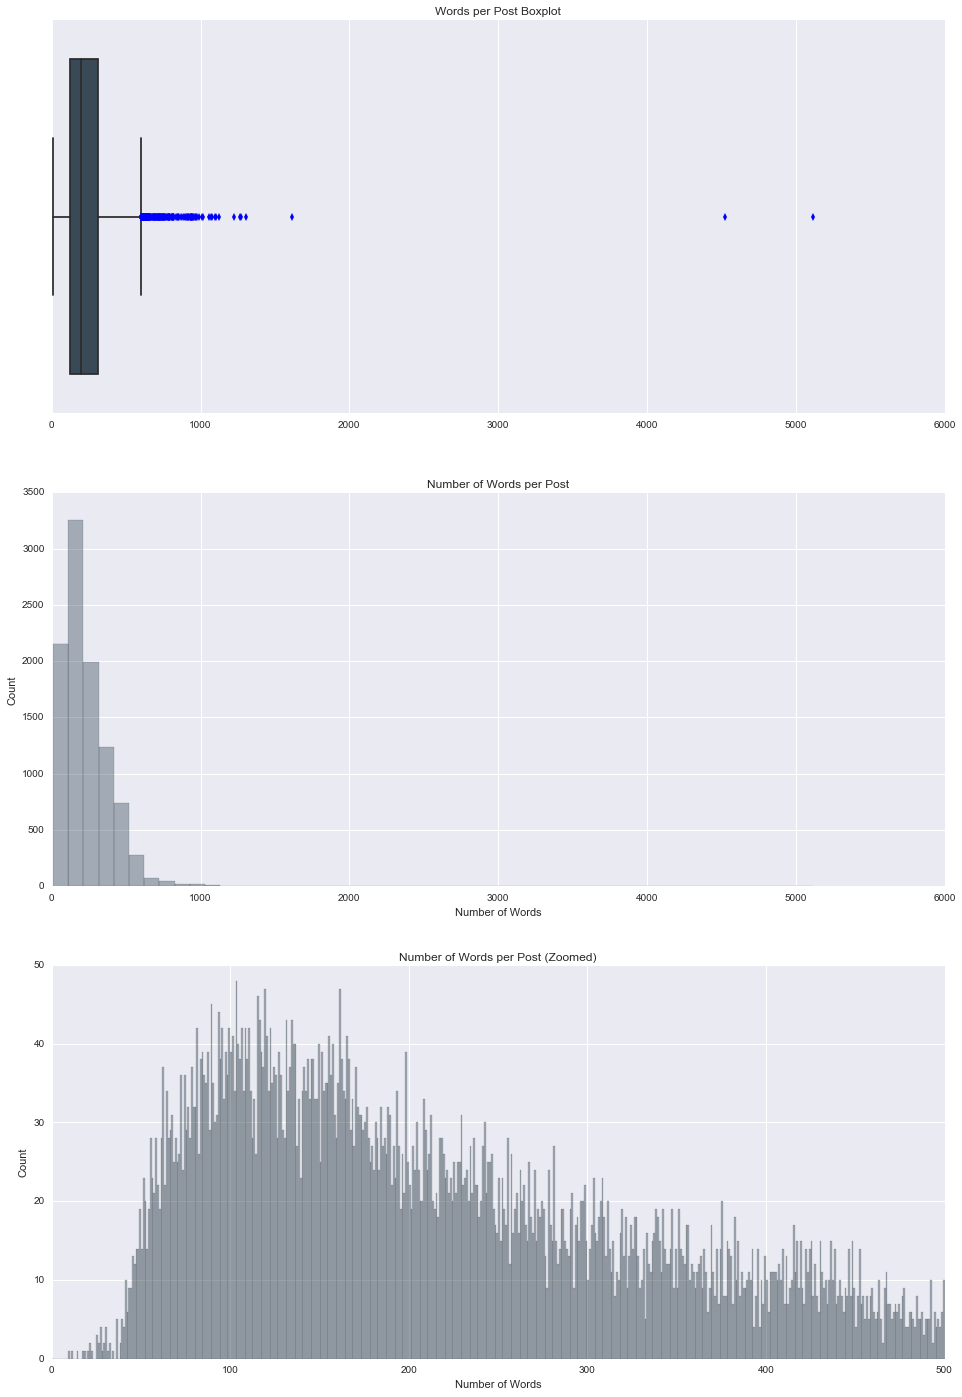

In [22]:
def explore_words_per_post(posts):
    """
    Explore and plot the number of words per post.

    Key arguments:
    
        posts -- The posts.
    """
    word_counts = np.zeros(len(posts.index))
    for i, (url, post) in enumerate(posts.iterrows()):
        word_counts[i] = len(post['body'].split(" "))

    # Print some general stats.
    print_general_stats(word_counts)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height'] * 3), ncols=1, nrows=3)
    
    # Draw boxplot.
    ax = sns.boxplot(x=word_counts, ax=axs[0])
    ax.set_title("Words per Post Boxplot")
    
    # Draw full distribution.
    ax = sns.distplot(word_counts, kde=0, ax=axs[1])
    ax.set_title("Number of Words per Post")
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Count')
    
    # Lets look at the number of posts with 500 or less words.
    word_counts_zoomed_idxs = np.where(word_counts <= 500)
    bins = range(0, 501)
    
    # Draw zoomed in distribution.
    ax = sns.distplot(word_counts[word_counts_zoomed_idxs], bins=bins, kde=0, ax=axs[2])
    ax.set_title("Number of Words per Post (Zoomed)")
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Count")
    
# Execute.
explore_words_per_post(posts.copy())

Looking at the distribution, it looks like the bulk of the posts are sub 600 words with a mean of 200. This seems reasonable since I would expect each post to be a few paragraphs.

#### Comments per Post

General Stats:
--------------
Mean:		11.518681
Median:		6.000000
Std. Dev.:	13.677241

Top 15 Smallest Values:	[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Top 15 Largest Values:	[ 78.  78.  79.  79.  80.  80.  81.  83.  84.  85.  86.  90.  90.  91.  91.]



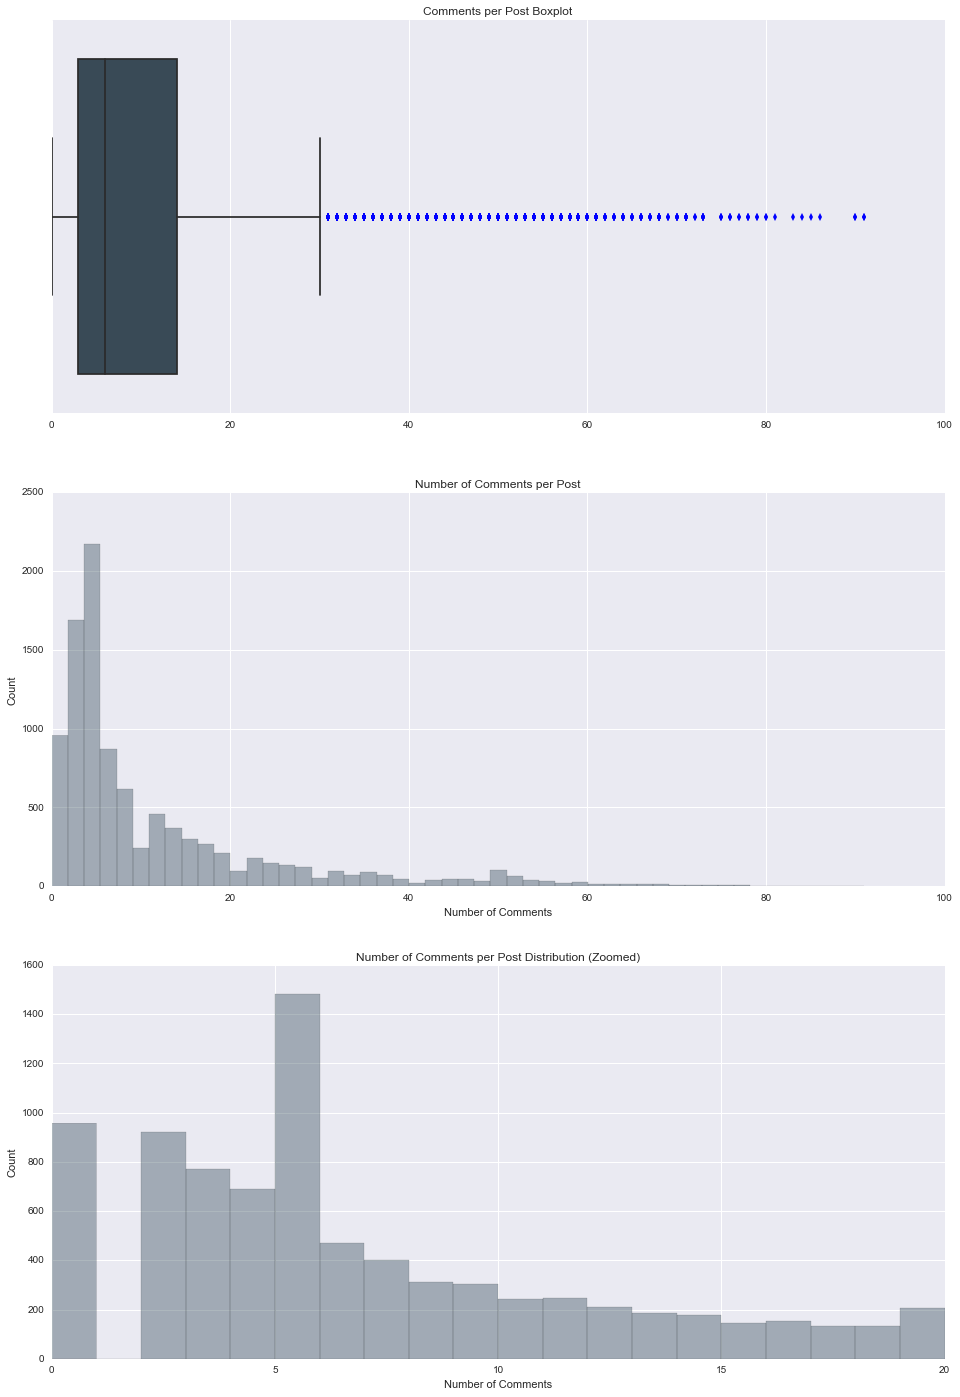

In [24]:
def explore_comments_per_post(posts, comments):
    """
    Explore and plot the number of comments per post.

    Key arguments:
    
        posts    -- The posts.
        comments -- The post comments.
    """
    comment_counts = np.zeros(len(posts.index))
    for i, (url, post) in enumerate(posts.iterrows()):
        comment_counts[i] = len(comments.loc[url]) if url in comments.index else 0
            
    # Print some general stats.
    print_general_stats(comment_counts)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height'] * 3), ncols=1, nrows=3)

    # Draw boxplot.
    ax = sns.boxplot(x=comment_counts, ax=axs[0])
    ax.set_title("Comments per Post Boxplot")
    
    # Draw full distribution.
    ax = sns.distplot(comment_counts, kde=0, ax=axs[1])
    ax.set_title("Number of Comments per Post")
    ax.set_xlabel('Number of Comments')
    ax.set_ylabel('Count')
    
    # Lets look at the number of posts with 20 or less comments.
    comment_counts_zoomed_idxs = np.where(comment_counts <= 20)
    bins = range(0, 21)
    
    # Draw zoomed in distribution.
    ax = sns.distplot(comment_counts[comment_counts_zoomed_idxs], bins=bins, kde=0, ax=axs[2])
    ax.set_title("Number of Comments per Post Distribution (Zoomed)")
    ax.set_xlabel("Number of Comments")
    ax.set_ylabel("Count")
    
# Execute.
explore_comments_per_post(posts.copy(), comments.copy())

Each post has a median of ~6 comments, and quite a few had 40+. One thing that stands out is the complete lack of posts with one comment (see below)... I'm still pondering why this would be, other than a random phenomenon. 

In [29]:
def explore_comments_with_one_post(posts, comments):
    """
    Explore the number of posts with one comment.

    Key arguments:
    
        posts    -- The posts.
        comments -- The post comments.
    """
    comment_counts = np.zeros(len(posts.index))
    for i, (url, post) in enumerate(posts.iterrows()):
        comment_counts[i] = len(comments.loc[url]) if url in comments.index else 0
    
    one_comment_count = len(np.where(comment_counts == 1)[0])
    
    print("Number of posts with one comment: {0}".format(one_comment_count))
        
# Execute.
explore_comments_with_one_post(posts.copy(), comments.copy())

Number of posts with one comment: 0


#### Words per Comment

General Stats:
--------------
Mean:		36.580357
Median:		28.000000
Std. Dev.:	32.655881

Top 15 Smallest Values:	[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Top 15 Largest Values:	[  485.   510.   513.   543.   549.   581.   585.   598.   599.   611.
   618.   634.   640.   738.  1247.]



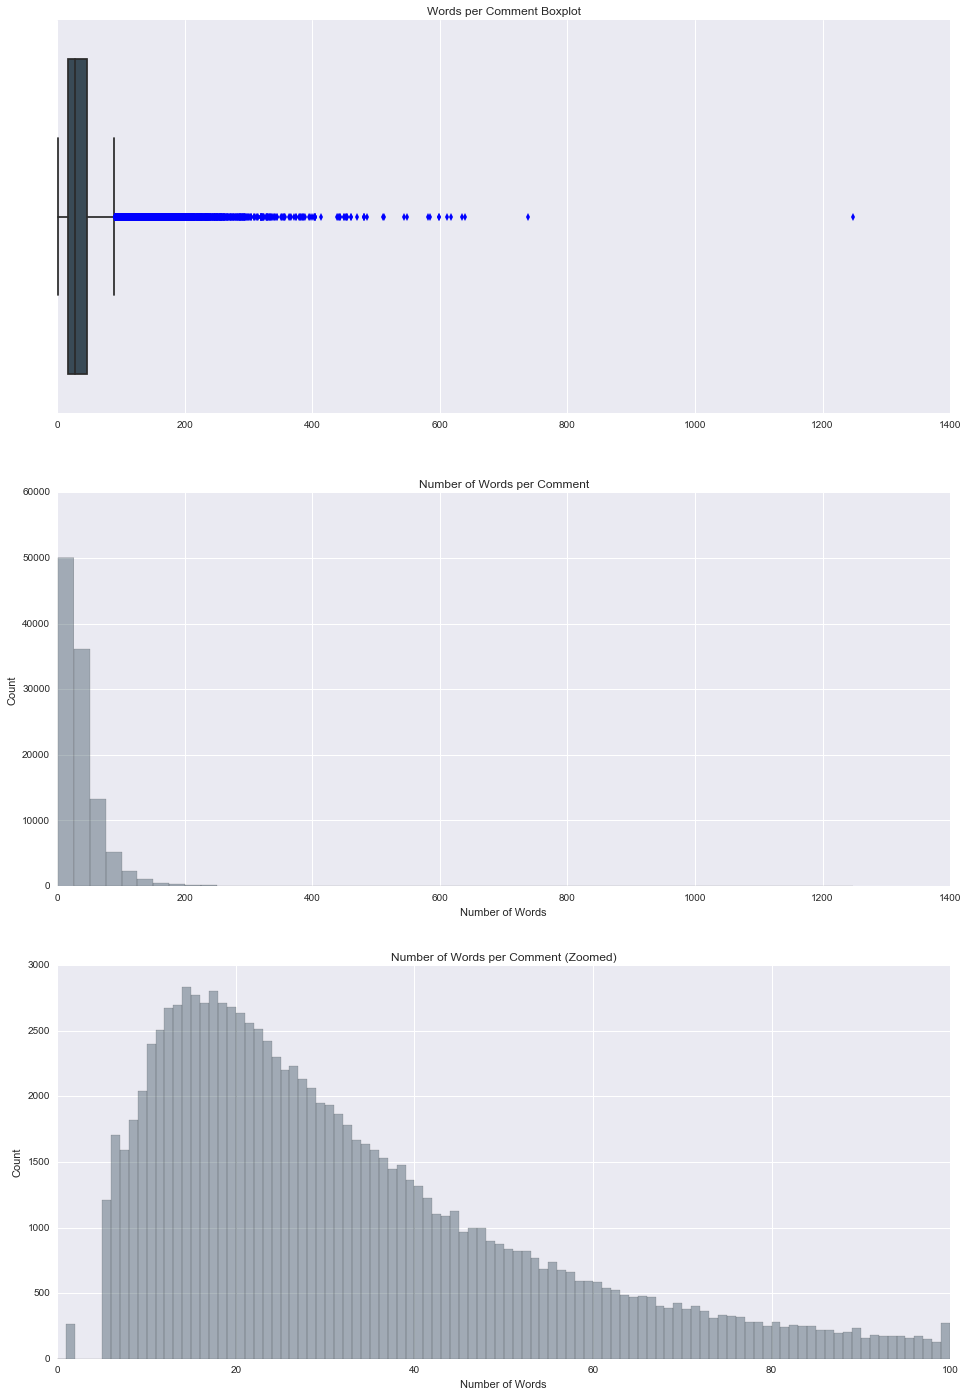

In [31]:
def explore_words_per_comment_per_post(comments):
    """
    Explore and plot the number of words per comment.

    Key arguments:
    
        comments -- The post comments.
    """
    word_counts = np.zeros(len(comments.index))
    for i, (url, comment) in enumerate(comments.iterrows()):
        word_counts[i] = len(comment['body'].split(" "))

    # Print some general stats.
    print_general_stats(word_counts)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height'] * 3), ncols=1, nrows=3)

    # Draw boxplot.
    ax = sns.boxplot(x=word_counts, ax=axs[0])
    ax.set_title("Words per Comment Boxplot")

    # Draw full distribution.
    ax = sns.distplot(word_counts, kde=0, ax=axs[1])
    ax.set_title("Number of Words per Comment")
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Count')
    
    # Lets look at the number of comments with 100 or less words.
    word_counts_zoomed_idxs = np.where(word_counts <= 100)
    bins = range(0, 101)
    
    # Draw zoomed in distribution.
    ax = sns.distplot(word_counts[word_counts_zoomed_idxs], bins=bins, kde=0, ax=axs[2])
    ax.set_title("Number of Words per Comment (Zoomed)")
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Count")
    
# Execute.
explore_words_per_comment_per_post(comments)

The median number of words per comment is ~28 - which is more than I expected (I assumed there would be a lot of "I love Disney!!" type posts). There is one extreme outlier where someone wrote a 1200 word comment. Out of curiosity, I wanted to take a look at this post. I assumed the comment was either a) someone who really likes to tell strangers what's on their mind or b) someone who was ranting about their time at Disney.


I was wrong on both counts.


In short, the comment is from a father thanking Disney for the absolutely wonderful time he and his daughter had at Disneyland. One of the wonderful aspects about exploration is that for curious people like myself, you never know what to expect. Sometimes, what you find might be quite inspiring!

In [36]:
def explore_long_comment(comments):
    """
    Explore the long comment.

    Key arguments:
    
        comments -- The post comments.
    """
    word_counts = np.zeros(len(comments.index))
    for i, (url, comment) in enumerate(comments.iterrows()):
        word_counts[i] = len(comment['body'].split(" "))

    idx = np.where(word_counts == 1247)[0]
    long_comment = comments.iloc[idx]
    print("Long comment: {0}".format(long_comment['body'].values))
    
# Execute.
explore_long_comment(comments)

Long comment: [ '    In keeping with the theme of Disneyland Park in 2009, I wanted to tell everyone about my very best day at Disneyland in January 2009.    My name is Jeffrey and my family is my wife, Jill, and my children, Jenna (5 years old) and Jake (8 months old).  My very first trip to Disneyland was last January 2009 when my wife and I took our daughter, Jenna.  That was four months before our son, Jake, was born and we adopted him (we adopted him at birth).    I knew I was going to be in Newport Beach for half the week in January 2009 at a conference for the Alzheimer’s Association.  I am a Board Member of the Alzheimer’s Association, NYC Chapter, and was attending the conference.  I added days to the trip at the beginning of the week and brought my wife and daughter, to have a mini vacation.  We wanted to bring our daughter to Disneyland.  We had a trip scheduled to Disney World coming up in April 2009, so wanted to bring Jenna to Disneyland to “see how she did”.  She did bea

#### Likes per Post

General Stats:
--------------
Mean:		1100.919503
Median:		257.000000
Std. Dev.:	4458.275526

Top 15 Smallest Values:	[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
Top 15 Largest Values:	[  50764.   55757.   57496.   61956.   63338.   64550.   65985.   69038.
   71255.   72269.   81914.   86946.   97675.  133414.  134380.]



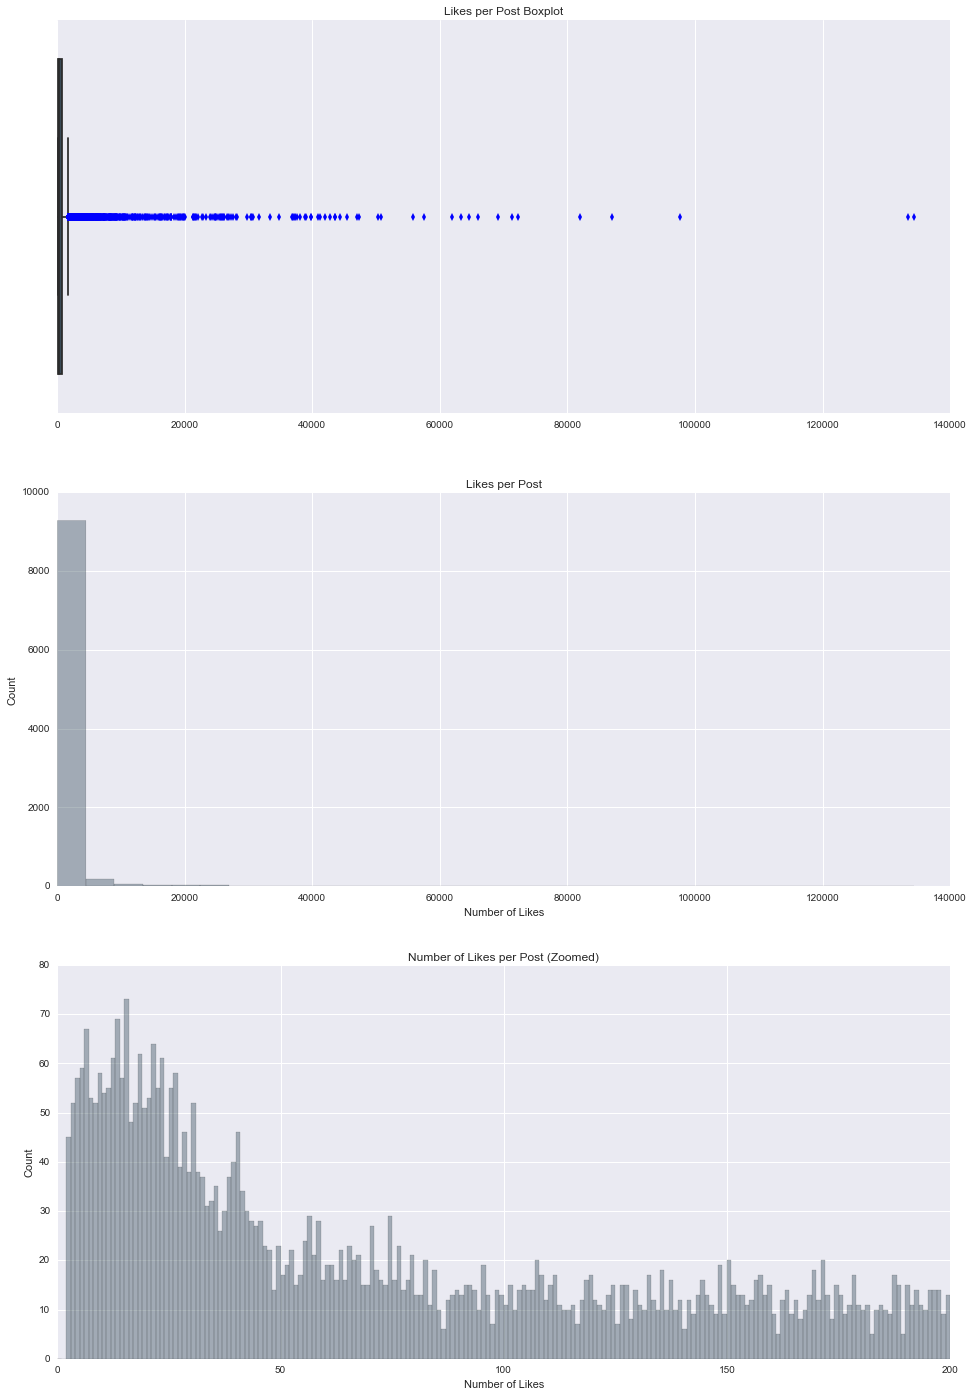

In [41]:
def explore_likes_per_post(posts):
    """
    Explore and plot the number of facebook likes per post.

    Key arguments:
    
        posts -- The posts.
    """
    like_counts = np.zeros(len(posts.index))
    for i, (url, post) in enumerate(posts.iterrows()):
        like_counts[i] = post['facebook_likes'] if post['facebook_likes'] != None else np.nan
    
    # Don't include any posts where we could not determine the number of likes in pre-processing.
    like_counts = like_counts[~np.isnan(like_counts)]

    # Print some general stats.
    print_general_stats(like_counts)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height'] * 3), ncols=1, nrows=3)

    # Draw boxplot.
    ax = sns.boxplot(x=like_counts, ax=axs[0])
    ax.set_title("Likes per Post Boxplot")
    
    # Draw full distribution.
    ax = sns.distplot(like_counts, kde=0, bins=30, ax=axs[1])
    ax.set_title("Likes per Post")
    ax.set_xlabel('Number of Likes')
    ax.set_ylabel('Count')
    
    # Lets look at the number of posts with 200 or less likes.
    like_counts_zoomed_idxs = np.where(like_counts < 200)
    bins = range(0, 201)
    
    # Draw zoomed in distribution.
    ax = sns.distplot(like_counts[like_counts_zoomed_idxs], bins=bins, kde=0, ax=axs[2])
    ax.set_title("Number of Likes per Post (Zoomed)")
    ax.set_xlabel("Number of Likes")
    ax.set_ylabel("Count")
    
# Execute.
explore_likes_per_post(posts.copy())

The median number of likes per post was about 258, with a rather large deviation. Some posts had over 100,000 likes (more on these later)!

### Varied Exploration

I've plotted some generic distributions... Lets take a look at some other potentially interesting features.

#### Most Popular Posts  (by Number of Comments)

In [38]:
def explore_popular_posts_by_comments(posts, comments, filings, top):
    """
    Explore the most popular posts ranked by the number of comments.

    Key arguments:
    
        posts     -- The posts.
        comments: -- The post comments.
        filings:  -- The post filings.
        top:      -- The max number of posts to show.
    """
    # Init the comment count to 0 for every row.
    posts['comment_count'] = 0
    
    # Simple function that counts the comments for every post
    def count_comments(post):
        post['comment_count'] = len(comments.loc[post['url']]) if post['url'] in comments.index else 0
        return post
    
    # Apply the count comments function to every row. We have to reset the index
    #  because pandas doesn't pass it during apply().
    posts = posts.reset_index().apply(count_comments, axis=1)
    posts.set_index('url', inplace=True)
    
    posts.sort_values('comment_count', ascending=False, inplace=True)
    
    posts_it = posts.iterrows()
    i = 0
    
    while i < top:
        url, post = next(posts_it)

        print("({0}) {1}".format(post['comment_count'], post['title']))
        print("\t{0}".format(datetime.fromtimestamp(int(post['timestamp'])).strftime("%Y-%m-%d")))
        filings_display = []
        if url in filings.index:
            filings_display = filings.loc[url]['filing']
            filings_display = filings_display.tolist() if not isinstance(filings_display, str) else [filings_display]
        print("\t{0}".format(filings_display))
        print("")
        
        i += 1

# Execute.
explore_popular_posts_by_comments(posts.copy(), comments.copy(), filings.copy(), 15)

(91) New Retail MagicBands and Accessories to Kick Off 2015 at Walt Disney World Resort
	2015-01-07
	['MagicBands', 'MyMagic+', 'Walt Disney World Resort']

(91) Book Frozen Summer Fun Premium Package at Disney’s Hollywood Studios
	2014-07-02
	["Disney's Hollywood Studios", 'Walt Disney World Resort']

(90) Preview of New Disney Parks Collection | PANDORA Jewelry Coming in March 2015
	2015-02-26
	['Disney California Adventure Park', 'Disneyland Park', 'Disneyland Resort', 'Epcot', 'Magic Kingdom', 'Walt Disney World Resort']

(90) Perfect Petals Brunch featuring the Disney Collection by Vera Bradley Coming to Epcot on May 4, 2014
	2014-03-19
	['Epcot', 'Walt Disney World Resort']

(86) First Look at New Items for Disney Princess Half Marathon Weekend 2015 at Walt Disney World Resort
	2015-02-10
	['Downtown Disney', 'MagicBands', 'MyMagic+', 'Walt Disney World Resort']

(85) First Look at Disneyland Resort Diamond Celebration Merchandise
	2015-03-23
	['Disneyland Park', 'Disneyland Reso

When sorting by the number of comments, no apparent trend is present. The topics seem to range from MagicBands, to Frozen, to park merchandise.

#### Most Popular Posts  (by Facebook Likes)

In [39]:
def explore_popular_posts_by_likes(posts, comments, filings, top):
    """
    Explore the most popular posts ranked by the number of likes.

    Key arguments:
    
        posts    -- The posts.
        comments -- The post comments.
        filings  -- The post filings.
        top      -- The top number of posts to show.
    """
    posts.sort_values('facebook_likes', ascending=False, inplace=True)
    
    posts_it = posts.iterrows()
    i = 0
    
    while i < top:
        url, post = next(posts_it)

        print("({0}) {1}".format(post['facebook_likes'], post['title']))
        print("\t{0}".format(datetime.fromtimestamp(int(post['timestamp'])).strftime("%Y-%m-%d")))
        filings_display = []
        if url in filings.index:
            filings_display = filings.loc[url]['filing']
            filings_display = filings_display.tolist() if not isinstance(filings_display, str) else [filings_display]
        print("\t{0}".format(filings_display))
        print("")
        
        i += 1

# Execute. Send a copy of posts since we will be manipulating it.
explore_popular_posts_by_likes(posts.copy(), comments.copy(), filings.copy(), 15)

(134380) Star Wars-Themed Lands Coming to Walt Disney World and Disneyland Resorts
	2015-08-15
	["Disney's Hollywood Studios", 'Disneyland Park', 'Disneyland Resort', 'Walt Disney World Resort']

(133414) Get Ready to Experience ‘Frozen’ Summer Fun – Live at Disney’s Hollywood Studios
	2014-06-26
	["Disney's Hollywood Studios", 'Walt Disney World Resort']

(97675) ‘Frozen’ Attraction Coming to Epcot
	2014-09-12
	["Disney's Hollywood Studios", 'Epcot', 'Magic Kingdom', 'Special Events', 'Walt Disney World Resort']

(86946) New Retail MagicBands and Accessories to Kick Off 2015 at Walt Disney World Resort
	2015-01-07
	['MagicBands', 'MyMagic+', 'Walt Disney World Resort']

(81914) Bringing the World of AVATAR to Life at Disney’s Animal Kingdom
	2015-02-26
	["Disney's Animal Kingdom", 'Walt Disney World Resort']

(72269) Disney Cruise Line Introduces 
	2015-02-11
	['Disney Cruise Line']

(71255) Seven Dwarfs Mine Train Opens May 28 at Walt Disney World Resort
	2014-05-02
	['Magic Kingdom'

Unlike sorting by comments, sorting by Facebook Likes shows a few prominent topics. Not surprisingly, Star Wars and Frozen top the list. One topic that surprised me was the number of popular cruise-related topics. I was intrigued enough to bookmark it for further analysis (more on this later).

#### Most Popular Topics (by Number of Comments)

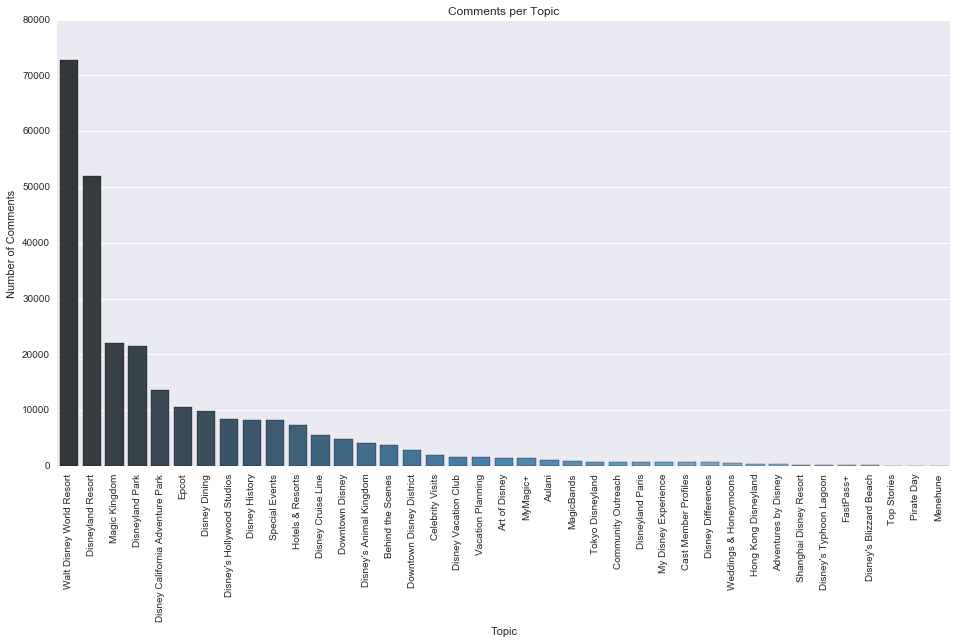

In [50]:
def explore_popular_topics_by_comments(posts, filings):
    """
    Explore the most popular posts ranked by the number of comments.

    Key arguments:
    
        posts   -- The posts.
        filings -- The post filings.
    """
    # Init the count to 0 for every row.
    filings['comment_count'] = 0
    
    # Simple function that counts the number of comments for every topic.
    def count_comments(filing):
        filing['comment_count'] = len(comments.loc[filing['url']]) if filing['url'] in comments.index else 0
        return filing
    
    # Apply the count comments function to every row. We have to reset the index
    #  because pandas doesn't pass it during apply().
    filings = filings.reset_index().apply(count_comments, axis=1)
    filings.set_index('url', inplace=True)
    
    grouped = filings.groupby('filing', as_index=False).sum()
    grouped.sort_values('comment_count', ascending=False, inplace=True)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    ax = sns.barplot(x='filing', y='comment_count', palette=META['plots']['palette'], data=grouped, ax=axs)
    ax.set_title("Comments per Topic")
    ax.set_xlabel("Topic")
    ax.set_ylabel("Number of Comments")
    
    # Make the labels vertical.
    for item in ax.get_xticklabels():
        item.set_rotation(90)

# Execute.
explore_popular_topics_by_comments(posts.copy(), filings.copy())

At a quick glance, it is apparent that the most popular topics are related to the parks with "Disney World" acting as a catch-all. Magic Kingdom seemed to be the most popular topic, followed by Epcot. 

#### Most Popular Topics (by Facebook Likes)

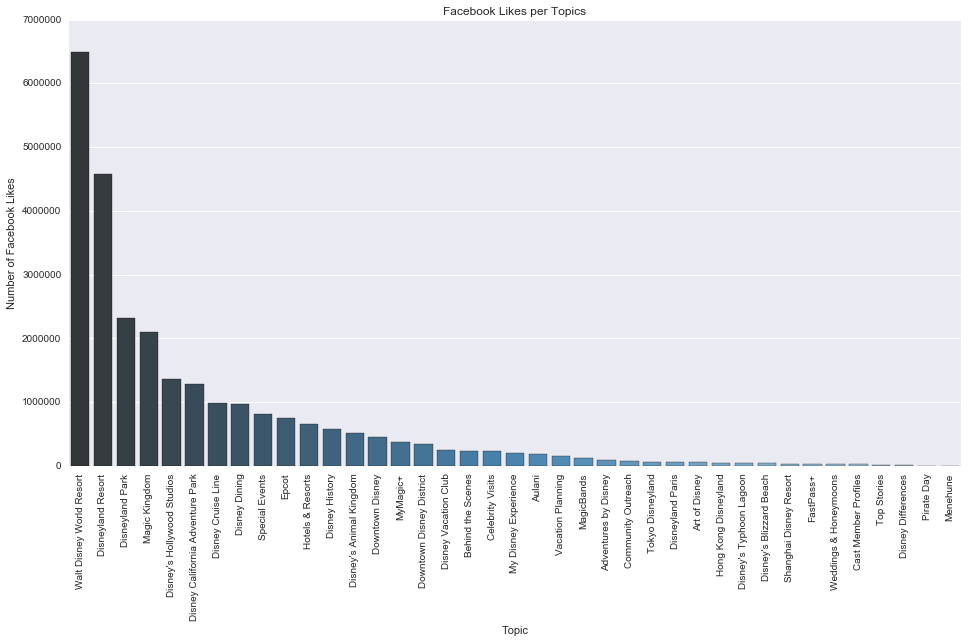

In [51]:
def explore_popular_topics_by_likes(posts, filings):
    """
    Explore the most popular posts ranked by the number of likes.

    Key arguments:
    
        posts   -- The posts.
        filings -- The post filings.
    """
    # Init the count to 0 for every row.
    filings['facebook_likes'] = 0
    
    # Simple function that counts the likes for every post.
    def count_likes(filing):
        filing['facebook_likes'] = posts.loc[filing['url']]['facebook_likes']
        return filing
    
    # Apply the count likes function to every row. We have to reset the index
    #  because pandas doesn't pass it during apply().
    filings = filings.reset_index().apply(count_likes, axis=1)
    filings.set_index('url', inplace=True)
    
    grouped = filings.groupby('filing', as_index=False).sum()
    grouped.sort_values('facebook_likes', ascending=False, inplace=True)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    ax = sns.barplot(x='filing', y='facebook_likes', palette=META['plots']['palette'], data=grouped, ax=axs)
    ax.set_title("Facebook Likes per Topics")
    ax.set_xlabel("Topic")
    ax.set_ylabel("Number of Facebook Likes")
    
    # Make the labels vertical.
    for item in ax.get_xticklabels():
        item.set_rotation(90)

# Execute.
explore_popular_topics_by_likes(posts.copy(), filings.copy())

Aggregating by Likes was very similar to aggregating by comments. 

#### Most Common Commenter Locations

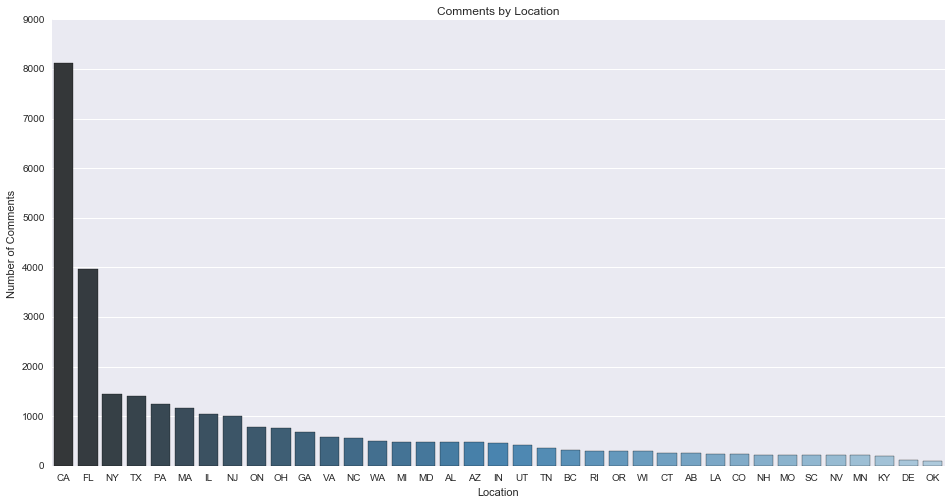

In [52]:
def explore_commenter_locations(comments):
    """
    Explore the locations of all the commenters.

    Key arguments:
        comments -- The comments.
    """
    # We only want to look at comments that are not the blog poster.
    comments_without_author = comments[comments['is_post_author'] == False]
    # Find all the unique locations and their counts.
    counts = comments_without_author['location'].value_counts()
    # Lets only look at locations that have more than 100 commentors.
    count_idx = np.where(counts.values > 100)

    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    ax = sns.barplot(x=counts.index[count_idx], y=counts.values[count_idx], palette=META['plots']['palette'], ax=axs)
    ax.set_title("Comments by Location")
    ax.set_xlabel("Location")
    ax.set_ylabel("Number of Comments")
    
# Execute.
explore_commenter_locations(comments.copy())

Not surprisingly, the majority of the comments came from CA, FL, NY, and TX (which also happen to be the biggest states by population).

#### Comments per Post Year

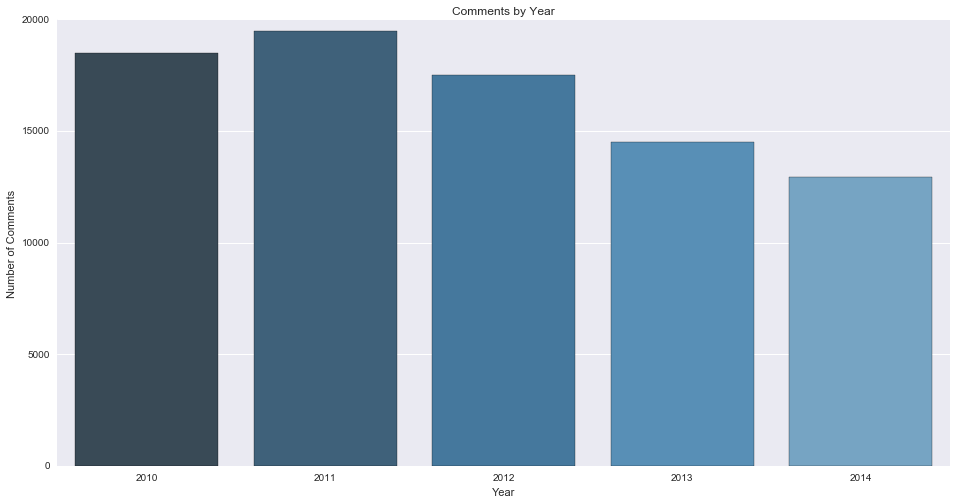

In [55]:
def explore_comments_per_post_year(posts, comments):
    """
    Explore the comments per year.
    
    Key arguments:
    
        posts    -- The posts.
        comments -- The comments.
    """
    
    # We only want to look at comments that are not the blog poster.
    comments = comments[comments['is_post_author'] == False].copy()
    
    # Merge the post timestamp into the comments.
    comments = pd.merge(comments, posts[['timestamp']], left_index=True, right_index=True, suffixes=('_comment', '_post'))
    
    # Determine the datetime using the post's timestamp.
    comments['datetime'] = pd.to_datetime(comments['timestamp_post'], unit='s')
    comments['year'] = comments['datetime'].map(lambda x: int(x.strftime('%Y')))
    
    # Remove 2009, 2015 since we have an incomplete data set for those years.
    comments = comments[(comments['year'] > 2009) & (comments['year'] < 2015)].copy()
    
    counts = comments['year'].value_counts()
    counts.sort_index(inplace=True)

    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    ax = sns.barplot(x=counts.index, y=counts.values, ax=axs)
    ax.set_title("Comments by Year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Comments")
    
# Execute.
explore_comments_per_post_year(posts.copy(), comments.copy())

Surprisingly, the number of comments seemed to decrease year after year. This could mean that either the blog was becoming less popular or an alternative means of feedback was being used...

#### Likes by Post Year

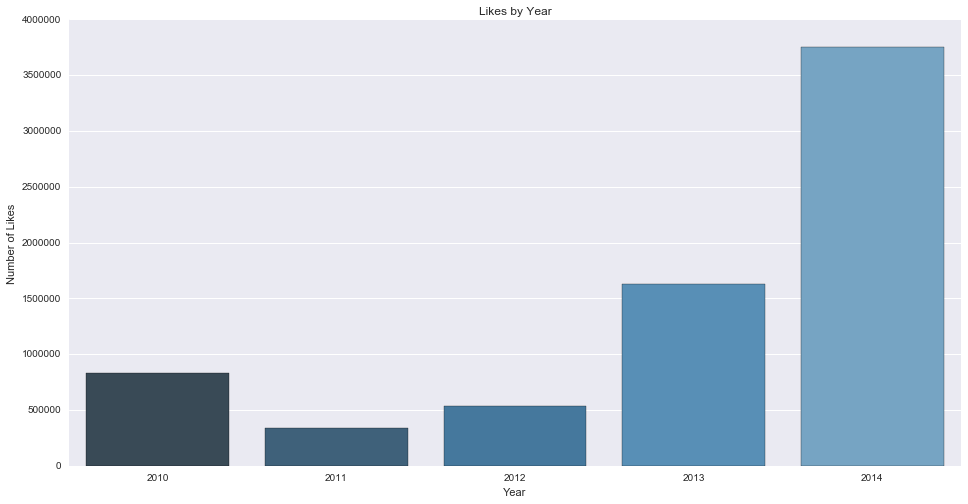

In [57]:
def explore_likes_by_post_year(posts):
    """
    Explore number of likes by year.

    Key arguments:
    
        posts -- The posts.
    """
    
    # Determine the year for each post.
    posts['datetime'] = pd.to_datetime(posts['timestamp'], unit='s')
    posts['year'] = posts['datetime'].map(lambda x: int(x.strftime('%Y')))
    
    # Remove 2009 since we have an incomplete data set for that year.
    posts = posts[(posts['year'] > 2009) & (posts['year'] < 2015)].copy()
    
    # Keep only facebook likes and year.
    posts = posts[['year', 'facebook_likes']].copy()
    
    grouped = posts.groupby('year', as_index=False).sum()
    grouped.sort_values('year', inplace=True)

    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    ax = sns.barplot(x='year', y='facebook_likes', data=grouped, ax=axs)
    ax.set_title("Likes by Year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Likes")
    
    
# Execute.
explore_likes_by_post_year(posts.copy())

Unlike the number of comments, the number of Facebook Likes have exploded year after year. The likely justification is two-fold:

- Facebook has been steadily rising in popularity
- It is easier for readers to press the "like button" than to write a comment.

Due to increased usage, I determined that Facebook Likes would be a better measure of popularity for future analysis.

#### Likes by Post Month

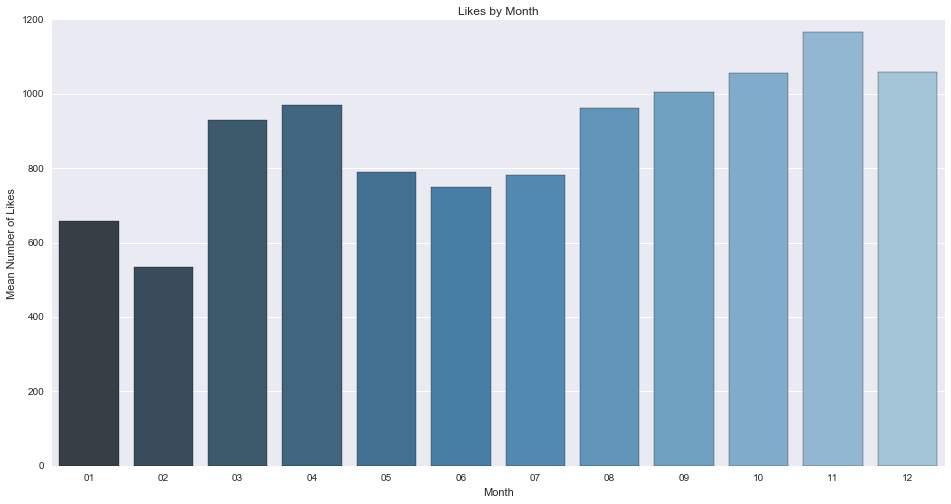

In [115]:
def explore_likes_by_post_month(posts):
    """
    Explore number of post likes by month.

    Key arguments:
    
        posts -- The posts.
    """
    
    # Determine the month for each post.
    posts['datetime'] = pd.to_datetime(posts['timestamp'], unit='s')
    posts['year'] = posts['datetime'].map(lambda x: int(x.strftime('%Y')))
    posts['month'] = posts['datetime'].map(lambda x: x.strftime('%m'))
    
    # Keep only recent years and drop 2015 since we have an incomplete data set.
    posts = posts[(posts['year'] > 2010) & (posts['year'] < 2015)].copy()
    
    # Keep only facebook likes and month.
    posts = posts[['month', 'facebook_likes']].dropna().copy()
    posts['facebook_likes'] = pd.Series(posts['facebook_likes'], dtype=np.float)
    
    grouped = posts.groupby('month', as_index=False).mean()
    grouped.sort_values('month', inplace=True)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    ax = sns.barplot(x='month', y='facebook_likes', data=grouped, palette=META['plots']['palette'], ax=axs)
    ax.set_title("Likes by Month")
    ax.set_xlabel("Month")
    ax.set_ylabel("Mean Number of Likes")
    
# Execute.
explore_likes_by_post_month(posts.copy())

When aggregating the number of likes by month, we see a fairly consistent pattern. The exceptions is February, which had a slightly smaller average number of Likes.

#### Likes by Post Day of Week

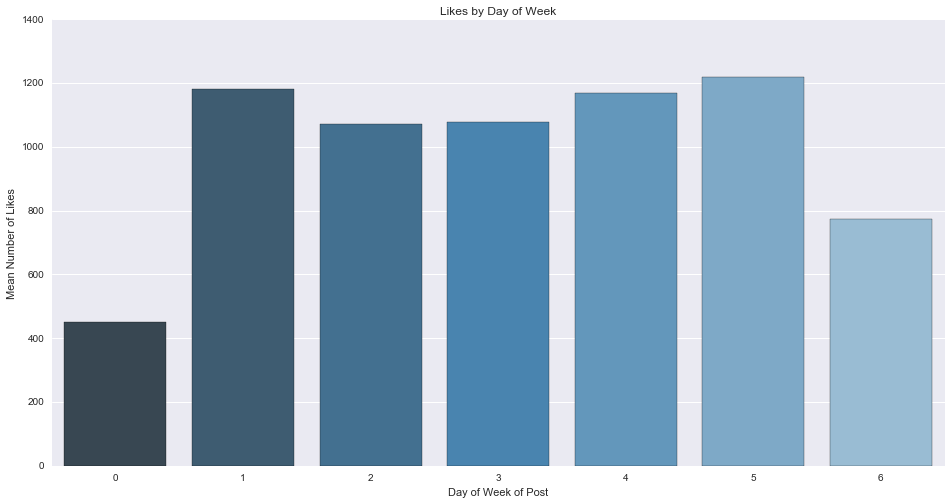

In [124]:
def explore_likes_by_post_dow(posts):
    """
    Explore number of post likes by month.

    Key arguments:
    
        posts -- The posts.
    """
    
    # Determine the month for each post.
    posts['datetime'] = pd.to_datetime(posts['timestamp'], unit='s')
    posts['dow'] = posts['datetime'].map(lambda x: x.strftime('%w'))
    
    # Keep only facebook likes and month.
    posts = posts[['dow', 'facebook_likes']].dropna().copy()
    posts['facebook_likes'] = pd.Series(posts['facebook_likes'], dtype=np.float)
    
    grouped = posts.groupby('dow', as_index=False).mean()
    grouped.sort_values('dow', inplace=True)
    
    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    #sns.palplot()
    ax = sns.barplot(x='dow', y='facebook_likes', data=grouped, palette=META['plots']['palette'], ax=axs)
    ax.set_title("Likes by Day of Week")
    ax.set_xlabel("Day of Week of Post")
    ax.set_ylabel("Mean Number of Likes")
    
    
# Execute.
explore_likes_by_post_dow(posts.copy())

When aggregating the number of likes by month, we see an obvious pattern. Both Saturday and Sunday (the weekend) have a significantly lower average number of Likes.

#### Comments by Time of the Day

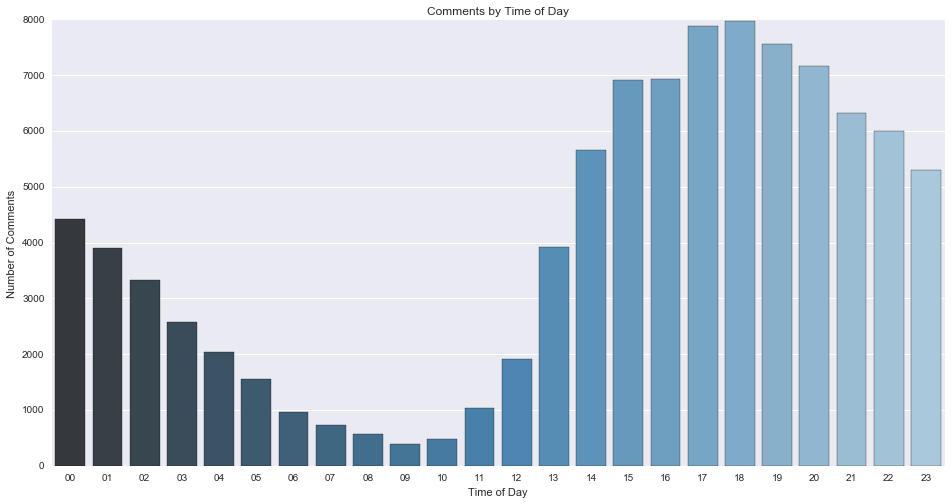

In [122]:
def explore_comments_by_time_of_day(comments):
    """
    Explore the most common time of day for comments.

    Args:
    
        comments -- The comments.
    """
    
    # We only want to look at comments that are not the blog poster.
    comments = pd.DataFrame(comments[comments['is_post_author'] == False])
    comments['datetime'] =  pd.to_datetime(comments['timestamp'], unit='s')
    comments['tod'] =  comments['datetime'].map(lambda x: x.strftime('%H'))
    
    counts = comments['tod'].value_counts()
    counts.sort_index(inplace=True)

    fig, axs = plt.subplots(figsize=(META['plots']['width'], META['plots']['height']), ncols=1, nrows=1)
    
    # Draw bar plot.
    ax = sns.barplot(x=counts.index, y=counts.values, palette=META['plots']['palette'], ax=axs)
    ax.set_title("Comments by Time of Day")
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Number of Comments")
    
# Execute.
explore_comments_by_time_of_day(comments.copy())

Based on the number of comments by time of day, it is evident that people prefer posting comments in the afternoon or evening (Eastern Standard Time). This is unsurprising as 0800-1000 EST most people are either getting ready for work or are not even up yet!

### Exploration Analysis and Questions

At this point, some basic exploration of the data set is complete. Some things to note:

- Most of the counts follow a Poisson-like distribution.
- Facebook Likes are increasing year after year and are likely a better estimate of "popularity".
- Popular Disney topics are the movies (Star Wars and Frozen) and the parks (Magic Kingdom and Epcot).
- The most active States in regards to the blog are CA, FL, TX, and NY.
- There appears to be distinct days/times when the blog is more "active".

Deeper analysis can be performed based on the findings from the basic exploration (e.g. What are some common topics amongst the most popular posts?). Ultimately, analysis that will be beneficial for the company is important - not just interesting facts. Topics that comes to mind are:

- Why are cruise line posts so popular?
- Is there an advantage to posting on a weekday vs. weekend or morning vs. evening?
- Can we identify "negative" comments? (Comments where the user seems angry)

## Cruising on the Rise

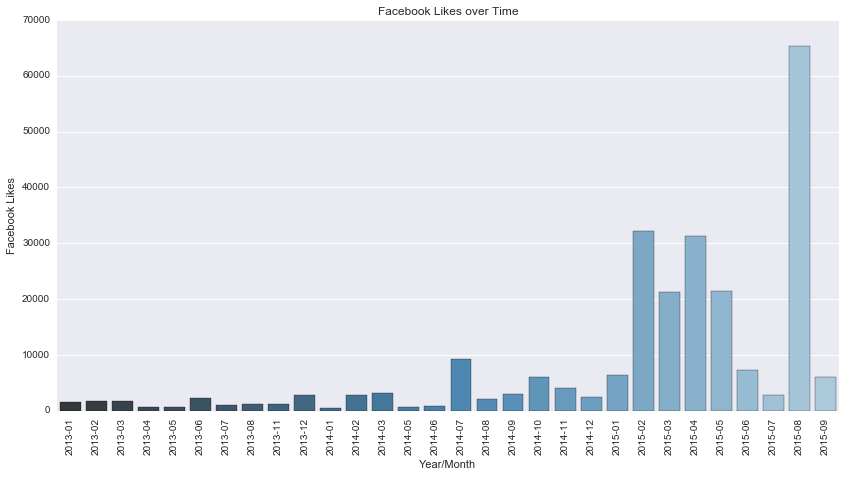

In [127]:
def analyze_cruise_lines(posts, filings):
    """
    Explore the cruise lines.

    Key arguments:
    
        posts   -- The posts.
        filings -- The post filings.
    """
    
    cruise_filings = filings[filings['filing'] == "Disney Cruise Line"]
    assert(np.all(cruise_filings['filing'].values == "Disney Cruise Line"))
    
    # Merge the filings and the posts
    cruise_posts = pd.merge(posts, cruise_filings, how='right', left_index=True, right_index=True)
    
    # Use the post's timestamp to determine the datetime.
    cruise_posts['datetime'] = pd.to_datetime(cruise_posts['timestamp'], unit='s')
    cruise_posts['year'] = cruise_posts['datetime'].map(lambda x: int(x.strftime('%Y')))
    cruise_posts['month'] = cruise_posts['datetime'].map(lambda x: x.strftime('%m'))
    
    # We're going to be using facebook likes to measure popularity.
    #  only look at recent years.
    cruise_posts = cruise_posts[cruise_posts['year'] >= 2013].dropna().copy()
    
    # Keep only the year, month, and facebook likes.
    cruise_posts = cruise_posts[['year', 'month', 'facebook_likes']]
    cruise_posts['facebook_likes'] = cruise_posts['facebook_likes'].map(lambda x: int(x))
    
    # Group our items by year and month and find the mean number of facebook likes.
    grouped = cruise_posts.groupby(['year', 'month'], as_index=False).sum()
    grouped['id'] = grouped[['year', 'month']].apply(lambda x: "{0}-{1}".format(x[0], x[1]), axis=1)
    
    ax = sns.barplot(x="id", y="facebook_likes", data=grouped, palette=META['plots']['palette'])
    
    ax.set_title("Facebook Likes over Time")
    ax.set_xlabel("Year/Month")
    ax.set_ylabel("Facebook Likes")
    
    # Make the labels vertical.
    for item in ax.get_xticklabels():
        item.set_rotation(90)
    
analyze_cruise_lines(posts.copy(), filings.copy())

### Summary

Deeper analysis conflicts with what was observed when the top posts by Facebook Likes were analyzed. Although there were a few Cruise Line posts that were popular, Cruise Lines Likes is consistenly low. The exceptions were a brief spike during the the winter of 2015 and the large spike in August of 2015 which was a single post publicizing the availability of Cruise Lines in New York.

Based on Facebook Likes, there seems to be no evidence that Disney Cruise Lines are consistently growing in popularity.

How could this information be beneficial? According to Cruise Market Watch, the predicted amount of cruise line passengers is increasing.

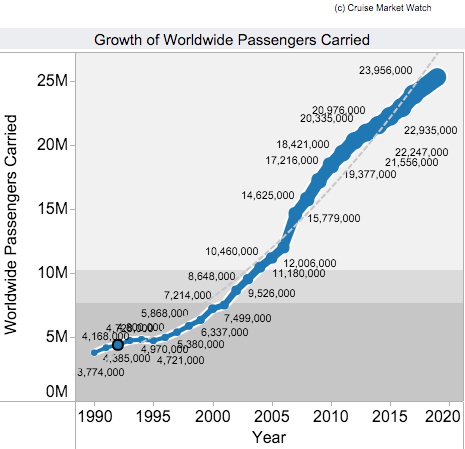

In [130]:
from IPython.display import Image
Image(filename='img/cruises.png')

If crusing in general is growing in popularity, but Disney Cruise Lines is not, Disney Corporation could be missing out on potential growth. 

## Weekday vs. Weekend Posts

Earlier it was observed that there was a distinct difference in the number of Facebook Likes between posts that were on the weekdays and posts that were on the weekend. A Hypothesis Test can be used to show if the apparent difference is caused by chance.

*Null Hypothesis*: There is no difference in the number of Facebook Likes between weekday and weekend.

In [141]:
def weekday_vs_weekend_popularity(posts):
    """
    """
    
    # Determine the day of the week (dow) for each post.
    posts['datetime'] = pd.to_datetime(posts['timestamp'], unit='s')
    posts['year'] = posts['datetime'].map(lambda x: int(x.strftime('%Y')))
    posts['dow'] = posts['datetime'].map(lambda x: int(x.strftime('%w')))
    
    # Take a look at only the recent years.
    posts = posts[posts['year'] >= 2011].dropna().copy()
    
    # Keep only facebook likes and dow.
    posts = posts[['dow', 'facebook_likes']].copy().dropna()
    
    posts_weekday = posts[(posts['dow'] != 0) & (posts['dow'] != 6)]
    posts_weekend = posts[(posts['dow'] == 0) | (posts['dow'] == 6)]
    
    # Sanity check.
    assert(len(posts) == len(posts_weekday) + len(posts_weekend))
    
    print("Weekday Sample Size:\t{0}".format(len(posts_weekday)))
    print("Weekday Variance:\t{0}".format(np.var(posts_weekday['facebook_likes'].values)))
    print("Weekend Sample Size:\t{0}".format(len(posts_weekend)))
    print("Weekend Variance:\t{0}".format(np.var(posts_weekend['facebook_likes'].values)))
    print()
    
    # Run a ttest for 2 independent samples. The weekday sample size is significnatly larger and has a different
    #  variance than the weekend sample. Use Welch's t-test.
    test = sp.stats.ttest_ind(
        posts_weekday['facebook_likes'].values, posts_weekend['facebook_likes'].values, equal_var=False)
    
    print("P-Value: {0}".format(test.pvalue))
    
weekday_vs_weekend_popularity(posts.copy())

Weekday Sample Size:	4308
Weekday Variance:	25971395.352810092
Weekend Sample Size:	514
Weekend Variance:	39515250.021771714

P-Value: 0.033073934743739646


### Summary

The p-value is less than the 5%, so the null hypothesis can be safely rejected. To be explicity clear, this only proves that the chances of seeing the observed difference is very unlikely to have happened by chance. It only provides *some* evidence that the reason for seeing the observed difference is due to the day of the week.

How could this information be beneficial? The blog is used as a method to publicize events at Disney. Based on the simple Hypothesis Test, it would *likely* be advantageous for a Blogger to post on the weekend in order to maximize popularity.

*Side note: At the time of writing this, the statistics community is having revolt against the misuse of p-values... I'll update this analysis should I discover that a different method is more appropriate.*

## Negative Comment Detection (Sentiment Analysis)

While sentiment is largely subjective, sentiment quantification can be very useful to businesses looking to understand consumer reactions.

In the case of Disney Corporation, finding negative sentiments would be extremely advantageous. If Disney could determine what areas customers were most dissatisfied, proper action could be taken to improve the situation.

In order to detect negative comments, a sentiment model must be constructed by training on postive and negative examples (supervised learning). The following methods are the step-by-step process in developing the sentiment model. 

*(For the tech-savy, I provided decent comments in the code for each phase. However, a deep understanding of Neural Networks and TensorFlow is required).*

### Training Data

The training data used to build the sentiment model came from a variety of sources. The largest source was Cornell's Movie Review data set which contained reviews of movies that were classified as "positive" (good review) or "negative" (bad review). The model was **not** trained on any of the comments from the Disney Blog as I did not have time to "hand" label thousands of comments. Once all the sources were obtained, they were merged into a single DataFrame.

In [142]:
def sentiment_display_details():
    """Display the sentiment dataframe."""
    
    df = sentiment_dataframe()
    print("Total: {:d}".format(len(df)))
    print("Positive Sentiments: {:d}".format(len(df[df['sentiment'] == 1])))
    print("Negative Sentiments: {:d}".format(len(df[df['sentiment'] == 0])))
    print("")
    print(df.head())

sentiment_display_details()

Total: 62705
Positive Sentiments: 31385
Negative Sentiments: 31320

   sentiment                                               text
0          1  now all apple has to do is get swype on the ip...
1          1  apple will be adding more carrier support to t...
2          1  hilarious youtube video - guy does a duet with...
3          1  rim you made it too easy for me to switch to a...
4          1  the 16 strangest things siri has said so far ....


### Cleaning Strings

In [143]:
def sentiment_clean(s):
    """
    Cleans the provided string for sentiment analysis.
    
    Key arguments:
    
        s -- The string to clean.
    
    Returns:
    
        A cleansed string.
    """
    # Add a space between punc. We don't want "great." and "great!" to show as different words, but
    #  punc is important!
    s = re.sub("\s*\.+\s*", " . ", s)
    s = re.sub("\s*\*+\s*", "", s)
    # Comments tend to have patterns of !???!! or !!??!. Remove them for a simple question.
    s = re.sub("\s*(\!\?)+\s*", " ? ", s)
    s = re.sub("\s*(\?\!)+\s*", " ? ", s)
    # Remove HTML tags that people might have put in.
    s = re.sub("\<.+?\>", "", s)
    s = re.sub("\s*\,+\s*", " , ", s)
    s = re.sub("\s*\?+\s*", " ? ", s)
    s = re.sub("\s*\!+\s*", " ! ", s)
    s = re.sub("\(", "", s)
    s = re.sub("\)", "", s)
    s = re.sub("\<", "", s)
    s = re.sub("\>", "", s)
    s = re.sub("\\n", "", s)
    s = re.sub("\s*\"\s*", " \" ", s)
    # Comments tend to have &3 for love. lets formally change it to "love"
    s = re.sub("\s*&lt;3\s*", " love ", s)
    s = re.sub("\s*&\s*", " and ", s)
    # Get rid of Twitter style comments.
    s = re.sub("@", "", s)
    s = re.sub("#", "", s)
    s = s.lower().strip()
    
    return s

In [144]:
def test_sentiment_clean():
    """Test the sentiment_clean method."""
    
    assert(sentiment_clean("THAT WAS AWESOME!!!") == "that was awesome !")
    assert(sentiment_clean("@Apple has snazy products.") == "apple has snazy products .")
    assert(sentiment_clean("Don't show the rest. <b>bad html content!!</b>") 
           == "don't show the rest . bad html content !")
    assert(sentiment_clean("Do you like this statement!?!?") == "do you like this statement ?")
    assert(sentiment_clean("that was lame...)") == "that was lame .")
    assert(sentiment_clean("\"Quote me!!\"") == "\" quote me ! \"")
    
    print("pass")
    
test_sentiment_clean()

pass


### Building a Vocabulary

In [145]:
def sentiment_build_vocab(sentences, max_size=50000):
    """
    Builds a vocabulary and a inverse vocabulary dictionary based on provided sentences.
    
    We reserve the first index for "unknown" words (future words that haven't been seen or padding during training)
    
    Key arguments:
    
        sentences - A list of strings to build a dictionary from.
        max_size  - The maximum size of the dictionary.
    
    Returns:
    
        vocab     -- The vocabulary dictionary.
        vocab_inv -- The inverse vocabulary dictionary.
    """
    count = [['UNK', 0]]
    count.extend(
        collections.Counter(
            itertools.chain(*[sentence for sentence in sentences])
        ).most_common(max_size - 1)
    )
                 
    vocab = dict()
    i = 0
    for word, _ in count:
        vocab[word] = len(vocab)
        i += 1
        
    vocab_inv = dict(zip(vocab.values(), vocab.keys()))
    
    return vocab, vocab_inv

In [146]:
def test_sentiment_build_vocab():
    """Test the sentiment_build_vocab method."""
    
    sentences = ["word1 word2 word3 word4".split(" "), "word3 word4 word5".split(" "), "word3".split(" ")]
    
    vocab, vocab_inv = sentiment_build_vocab(sentences)
    
    #print(vocab)
    #print(vocab_inv)
    #print()
    
    assert(vocab["UNK"] == 0)
    assert(vocab_inv[0] == "UNK")
    assert(vocab["word3"] == 1)
    assert(vocab_inv[1] == "word3")
    
    # Try keeping only the top 3 words.
    vocab, vocab_inv = sentiment_build_vocab(sentences, max_size=3)
    
    #print(vocab)
    #print(vocab_inv)
    #print()
    
    assert(vocab["UNK"] == 0)
    assert(vocab_inv[0] == "UNK")
    try:
        assert(vocab["word5"] == 0)
    except KeyError:
        pass
    
    print("pass")
    
test_sentiment_build_vocab()

pass


### Vocabulary Lookup

In [147]:
def sentiment_vocab_lookup(vocab, word):
    """
    Looks up a word in the vocab dictionary. If the word does not exist,
    it returns the "unknown" index.
    
    Key arguments:
    
        vocab -- The vocabulary dictionary.
        word  -- The word to lookup.
    """
    
    return vocab[word] if word in vocab else 0

In [148]:
def test_sentiment_vocab_lookup():
    """Tests the sentiment_vocab_lookup method."""
    
    sentences = ["word1 word2 word3 word4".split(" "), "word3 word4 word5".split(" "), "word3".split(" ")]
    
    vocab, vocab_inv = sentiment_build_vocab(sentences, max_size=3)
    
    assert(sentiment_vocab_lookup(vocab, "UNK") == 0)
    assert(sentiment_vocab_lookup(vocab, "word3") == 1)
    
    # Try words that should not exist since they were not in the vocab.
    assert(sentiment_vocab_lookup(vocab, "word5") == 0)
    assert(sentiment_vocab_lookup(vocab, "blablabla") == 0)
    
    print("pass")
    
test_sentiment_vocab_lookup()

pass


### Labels

In [149]:
def sentiment_label(sentiment):
    """
    Given a JSON sentiment object, return a label that TensorFlow can understand.
    
    Key arguments:
    
        sentiment -- A JSON sentiment object.
    
    Returns:
    
        [1, 0] if the sentiment is positive and [0, 1] if the sentiment is negative.
    """
    
    return [1, 0] if sentiment == 1 else [0, 1]

In [150]:
def sentiment_label_inv(sentiment_label):
    """
    Given a sentiment_label, return a positive/negative (int) result.
    
    Key arguments:
    
        sentiment -- A JSON sentiment object.
    
    Returns:
    
        1 if the sentiment is positive and 0 if the sentiment is negative.
    """
    
    return 1 if np.all(sentiment_label == [1, 0]) else 0

In [151]:
def test_sentiment_label():
    """Test the sentiment_label method."""
    
    assert(sentiment_label(1) == [1, 0])
    assert(sentiment_label(0) == [0, 1])
    assert(sentiment_label_inv([1, 0]) == 1)
    assert(sentiment_label_inv([0, 1]) == 0)
    
    print("pass")

test_sentiment_label()

pass


### Vectorize Sentences

In [154]:
def sentiment_vectorize_sentence(vocab, sentence, min_size):
    """
    Vectorizes a sentence.
    
    If a sentence is smaller that min_size, it will be padded using vocab["UNK"]. Padding
    is necessary so that all sentences are the same length during mapping to sentence embeddings.
    
    Key arguments:
    
        vocab    -- The vocabulary.
        sentence -- The sentence to vectorize.
        min_size -- The minimum size of the sentence. Padding using vocab["UNK"] will be used to fill remaining space.
    """
    vec = [sentiment_vocab_lookup(vocab, word) for word in sentence]
    
    num_padding = min_size - len(vec)
    
    return np.array(vec + [vocab["UNK"]] * num_padding, dtype=np.int)

In [158]:
def test_sentiment_vectorize_sentence():
    """Tests the sentiment_vectorize_sentence method."""
    
    sentences = ["the cat is small .".split(" "), "the cat was large !".split(" ")]
    
    vocab, vocab_inv = sentiment_build_vocab(sentences)
    
    vec = sentiment_vectorize_sentence(vocab, "the cat".split(" "), 5)
    assert(len(vec) == 5)
    assert(vec[0] == 1)
    assert(vec[1] == 2)
    assert(vec[-1] == 0)
    
    assert([vocab_inv[idx] for idx in vec] == ['the', 'cat', 'UNK', 'UNK', 'UNK'])
    
    print("pass")
    
test_sentiment_vectorize_sentence()

pass


### Vectorize Sentiments

In [159]:
def sentiment_vectorize_sentiments(sentiments, max_size):
    """
    Vectorizes a list of sentiment (JSON) objects.
    
    Key arguments:
    
        sentiments -- 
        max_size   -- The maximum size of a sentiment sentence.
    """
    
    # Go through each sentiment, and only evaluate ones that are less than the max_size.
    sentences = []
    labels = []
    for idx, sentiment in sentiments.iterrows():
        sentence = sentiment['text'].split(" ")
        if (len(sentence) <= max_size):
            sentences.append(sentence)
            labels.append(sentiment_label(sentiment['sentiment']))
    
    # Build the vocabulary using the sentences.
    vocab, vocab_inv = sentiment_build_vocab(sentences)
    
    # Build a list of vectors using the sentences.
    vecs = []
    for sentence in sentences:
        vecs.append(sentiment_vectorize_sentence(vocab, sentence, max_size))
    
    return np.array(vecs, dtype=np.int), np.array(labels, dtype=np.int), vocab, vocab_inv

In [160]:
def test_sentiment_vectorize_sentiments():
    """Tests the sentiment_vectorize_sentiments method."""
    
    sentiments = sentiment_dataframe().iloc[:10]
    vecs, labels, vocab, vocab_inv = sentiment_vectorize_sentiments(sentiments, 100)
    test_vec = np.array(
        [sentiment_vocab_lookup(vocab, word) for word in sentiments.iloc[0]['text'].split(" ")], dtype=np.int)
    assert(np.all(test_vec == vecs[0][:len(test_vec)]))
    
    print("pass")
    
test_sentiment_vectorize_sentiments()

pass


### Model

In [161]:
class SentimentModel:
    """
    TensorFlow sentiment model using Convolutional Neural Networks.
    """
    
    def __init__(self, sentence_size, vocab_size, alpha=0.01):
        """
        Initializes the most important model variables.
        
        Key arguments:
        
            sentence_size -- The maximum size of a sentence.
            vocab_size    -- The size of the vocab.
            alpha         -- L2 normalization parameter.
        """
        self.state = {
            'sentence_size': sentence_size,
            'vocab_size': vocab_size,
            'alpha': alpha,
            
            # The number of classes (Positive and Negative sentiment)
            'num_classes': 2,
            # The embedding size of each sentence.
            'embedding_size': 300,
            # The filter sizes to use during convolution.
            'filter_sizes': [3, 4, 5],
            # The number of times to use each filter.
            'num_filters': 100,
        }
        
        #
        self.state['num_features'] = self.state['num_filters'] * len(self.state['filter_sizes'])
    
    def init_graph(self, graph):
        """
        Initializes the TensorFlow graph.
        
        Key arguments:
        
            graph -- The TensorFlow graph.
        """
        state = self.state
        
        with graph.as_default():
            # Set the feature and output label placeholders.
            self.x = tf.placeholder(tf.int32, [None, state['sentence_size']])
            self.y = tf.placeholder(tf.float32, [None, state['num_classes']])
            self.keep_prob = tf.placeholder(tf.float32)
            
            # Map each sentence vector (size of the vocabulary) to an embedding vector.
            embedded_weights = tf.Variable(tf.random_uniform([state['vocab_size'], state['embedding_size']], -1.0, 1.0))
            embedded_chars = tf.nn.embedding_lookup(embedded_weights, self.x)
            embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)

            # Each filter has a different convolution. Iterate through all and combine
            #  them all at the end.
            pools = []
            for i, filter_size in enumerate(state['filter_sizes']):
                filter_shape = [filter_size, state['embedding_size'], 1, state['num_filters']]

                weights = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1))
                biases = tf.Variable(tf.constant(0.1, shape=[state['num_filters']]))

                conv = tf.nn.conv2d(embedded_chars_expanded, weights, strides=[1, 1, 1, 1], padding="VALID")
                hidden = tf.nn.relu(tf.nn.bias_add(conv, biases))

                pool = tf.nn.max_pool(hidden, ksize=[1, state['sentence_size'] - filter_size + 1, 1, 1],
                                        strides=[1, 1, 1, 1], padding='VALID')
                pools.append(pool)

            # Merge the pooled layers.
            hidden_pool = tf.concat(3, pools)
            hidden_pool_flat = tf.reshape(hidden_pool, [-1, state['num_features']])

            # Dropout
            hidden_dropout = tf.nn.dropout(hidden_pool_flat, self.keep_prob)

            # Map eac
            weights = tf.Variable(tf.truncated_normal([state['num_features'], state['num_classes']], stddev=0.1))
            biases = tf.Variable(tf.constant(0.1, shape=[state['num_classes']]))
            
            # Determine scores and then find the max score to determine the best prediction.
            scores = tf.nn.xw_plus_b(hidden_dropout, weights, biases)
            self.predictions = tf.argmax(scores, 1,)

            # Calculate loss.
            losses = tf.nn.softmax_cross_entropy_with_logits(scores, self.y)
            self.loss = tf.reduce_mean(losses) + state['alpha'] * tf.nn.l2_loss(weights)

            # Calculate accuracy.
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predictions, tf.argmax(self.y, 1)), "float"))
            
            # Run the optimizer.
            optimizer = tf.train.AdamOptimizer(1e-4)
            grads_and_vars = optimizer.compute_gradients(self.loss)
            self.optimize = optimizer.apply_gradients(grads_and_vars)

### Training

In [163]:
def sentiment_train(x, y, vocab, filepath, batch_size=250, epochs=1000):
    """
    Trains a SentimentModel with the provided training set.
    
    Key arguments:
    
        x          -- The feature set (vector of sentences).
        y          -- The labels.
        vocab      -- The vocabulary dictionary.
        filepath   -- The file path to save the training model.
        batch_size -- The size of each iterative training batch.
        epochs     -- The number of epochs (random assortment of training vectors)
    """
    
    graph = tf.Graph()
    with graph.as_default():
        with tf.Session(graph=graph) as session:

            # Initialize a sentiment model.
            model = SentimentModel(len(x[0]), len(vocab))
            model.init_graph(graph)
            
            # Continue with a saved model if one exists.
            session.run(tf.initialize_all_variables())
            saver = tf.train.Saver(tf.all_variables())
            if os.path.isfile(filepath):
                print("Loading saved session fom {0}.".format(filepath))
                saver.restore(session, filepath)

            print("Initialized.")
            
            x_size = len(x)
            batches = int(x_size / batch_size) + 1
            
            # For each epoch, do a random assortment of the training sentences.
            for epoch in range(epochs):
                idx = np.random.permutation(np.arange(x_size))
                x_shuffled = x[idx]
                y_shuffled = y[idx]
                for batch in range(batches):
                    start_idx = batch * batch_size
                    end_idx = min((batch + 1) * batch_size, x_size)
                    
                    x_batch = x_shuffled[start_idx:end_idx]
                    y_batch = y_shuffled[start_idx:end_idx]
                    
                    # Feed our model with a dropout rate of 50%.
                    feed = {model.x: x_batch, model.y: y_batch, model.keep_prob: 0.5}
                    _, loss, accuracy = session.run([model.optimize, model.loss, model.accuracy], feed_dict=feed)
                    
                    # Print status and save model.
                    if (batch % 10 == 0):
                        print("Epoch {0} Batch {1} (L: {2}, A: {3})...".format(epoch, batch, loss, accuracy))
                        saver.save(session, filepath)

### Prediction

In [164]:
def sentiment_predict(x, vocab, filepath):
    """
    Predicts the provided feature (sentence) vectors using the model at filepath.
    """
    graph = tf.Graph()
    with graph.as_default():
        with tf.Session(graph=graph) as session:

            model = SentimentModel(len(x[0]), len(vocab), 0.0)
            model.init_graph(graph)

            session.run(tf.initialize_all_variables())
            saver = tf.train.Saver(tf.all_variables())
            saver.restore(session, filepath)
            
            # Use a fake label set.
            y = np.array([[0, 1]] * len(x))
            
            # Feed the model, but make sure to keep all of the values!
            feed = {model.x: x, model.y: y, model.keep_prob: 1.0}
            predictions = session.run([model.predictions], feed_dict=feed)
                
            return np.array(predictions[0] == 0, dtype=np.int)

### Execution

In [165]:
sentiment_vecs, sentiment_labels, sentiment_vocab, sentiment_vocab_inv = \
    sentiment_vectorize_sentiments(sentiment_dataframe(), 200)

#### Split into Train/Test

In [166]:
sentiment_x_train, sentiment_x_test, sentiment_y_train, sentiment_y_test = \
    train_test_split(sentiment_vecs, sentiment_labels, test_size=0.10, random_state=42)

In [167]:
print("Training Size:\t{0}".format(len(sentiment_y_train)))
print("Test Size:\t{0}".format(len(sentiment_y_test)))

Training Size:	47017
Test Size:	5225


#### Verify the Positive/Negative Distribution

In [168]:
print("Positive Training Examples:\t{0}".format(
        np.sum([np.array_equal(y, np.array([1, 0])) for y in sentiment_y_train])))
print("Negative Training Examples:\t{0}".format(
        np.sum([np.array_equal(y, np.array([0, 1])) for y in sentiment_y_train])))
print("Positive Test Examples:\t\t{0}".format(
        np.sum([np.array_equal(y, np.array([1, 0])) for y in sentiment_y_test])))
print("Negative Test Examples:\t\t{0}".format(
        np.sum([np.array_equal(y, np.array([0, 1])) for y in sentiment_y_test])))

Positive Training Examples:	23504
Negative Training Examples:	23513
Positive Test Examples:		2598
Negative Test Examples:		2627


#### Train the Model

In [ ]:
sentiment_train(sentiment_x_train, sentiment_y_train, sentiment_vocab, META['model']['sentiment'])

**Train Summary**

After many hours of training, the model was able to predict random positive/negative training samples with ~85% accuracy.

    ...
    Epoch 1 Batch 70 (L: 0.3615756034851074, A: 0.8519999980926514)...
    Epoch 1 Batch 80 (L: 0.38188397884368896, A: 0.8519999980926514)...
    Epoch 1 Batch 90 (L: 0.36195218563079834, A: 0.8640000224113464)...
    ...

*(Note: The training model accuracy is not a significant estimate because it is biased. Evaluation should always occur on data the model has never seen before!)*

#### Test the Model

In [174]:
def sentiment_test_model():
    """
    Analysis of the sentiment model using the test set.
    """
    
    y = np.array([sentiment_label_inv(yi) for yi in sentiment_y_test[:100]], dtype=np.int)
    predictions = sentiment_predict(sentiment_x_test[:100], sentiment_vocab, META['model']['sentiment'])
    
    print("Accuracy")
    print(accuracy_score(y, predictions))
    print()
    
    print("Precision")
    print(precision_score(y, predictions))
    print()
    
    print("Recall")
    print(recall_score(y, predictions))
    print()
    
    tp = len(np.where(y[np.where(y == predictions)] == 1)[0])
    tn = len(np.where(y[np.where(y == predictions)] == 0)[0])
    fp = len(np.where(predictions[np.where(y != predictions)] == 1)[0])
    fn = len(np.where(predictions[np.where(y != predictions)] == 0)[0])
    
    print("Negative Detection Accuracy")
    print(tn / (tn + fn))
    print()
    
    print("Confusion Matrix")
    print(confusion_matrix(y, predictions))
    print()
    
sentiment_test_model()

Accuracy
0.74

Precision
0.775510204082

Recall
0.716981132075

Negative Detection Accuracy
0.7058823529411765

Confusion Matrix
[[36 11]
 [15 38]]



**Test Summary**

Accuracy for the test set was ~74% - about a 11% difference from the training accuracy. However, in this scenario, the more important statistic is the rate at which the model could accuractely determine negative sentiments. The negative detection accuracy for the model is ~71% which is by no means production ready, but is significantly better than flipping a coin (50%). It was also high enough to continue forward and evaluate using comments from Disney's Blog.

#### Test Blog Comments

To test blog comments, I selected 10 positive and 10 negative comments. The model was then applied to predict the sentiment of each sentence.

*(Note: I "randomly selected" comments - but I'm human and am therefore biased. I looked for comments that were intuitively positive or negative.)*

In [170]:
def sentiment_test_comments(title, filepath, max_size):
    """
    Reads in pre-determined comments and predicts their sentiments.
    
    Key arguments:
    
        title    -- The title to print.
        filepath -- The file location of the comments.
        max_size -- The max sentence size.
    """
    
    with open(filepath) as file:    
        comments = json.load(file)
    
    # Conver the comments to vocab vectors.
    vecs = []
    for comment in comments:
        comment = sentiment_clean(comment).split(" ")
        if (len(comment) <= max_size):
            vecs.append(sentiment_vectorize_sentence(sentiment_vocab, comment, max_size))
    
    vecs = np.array(vecs, dtype=np.int)
    predictions = sentiment_predict(vecs, sentiment_vocab, META['model']['sentiment'])
    
    print(title)
    for i in range(len(predictions)):
        print("({0}) {1}".format(predictions[i], comments[i]))
    print()
    
sentiment_test_comments("Positives", "data/sentiment/comments-positive.json", 200)
sentiment_test_comments("Negatives", "data/sentiment/comments-negative.json", 200)

Positives
(1)     I’m not a wine drinker, but I always love this for the food!!!
(1)     This is fantastic!!! It also made me incredibly hungry reading it. I must get food now…    But seriously, Love the fact we got some recipes on here! The Food and Wine festival is my all time favorite celebration done at a Disney Theme Park. How can you not love walking around countries trying out different foods that you otherwise wouldn’t have even given a try?!    Forget getting the food, I’m driving to Epcot. See you in a few! ;]
(1)     Thanks for the recipe for Aunt Peggy’s Pickled Cucumber, Tomato, and Onion Salad!   I will definitely be trying this – it’s always great to find new vegan recipes.  This will work out great to make ahead of time for my dinner party this weekend!  Thanks a bunch!
(1)     I love,love,love Disney!!!!! But my favorite event is Food and Wine!!! We enjoy the events and just walking around and eating all the different foods and tasting all the different wines. It makes

**Test Blog Comments Summary**

The model was able to predict 8/10 positive sentences and 8/10 negative sentences correctly. I was troubled by the first negative comment which the model predicted as positive ("It bothers me sooo much when people refer..."). The comment is clearly negative, which leads me to believe that the training set is missing vocabulary (i.e. the model never learned how to classify "it bothers me") or is not particularly stable at predicting longer comments. 

The second negative comment contains no obvious negative words and therefore would be very difficult for the model to predict accurately. This raises a good point that the model will have a difficult time predicting "weak negative" or "neutral" comments.

### Detect Negative Sentiments

Now for the real test... Can we scan through the blog and determine negative comments?

In [176]:
def sentiment_detect_negative_comments(comments, max_size, year, num_comments):
    """
    Scans through the blog and looks for negative comments
    
    Key arguments:
    
        comments     -- The blog comments.
        max_size     -- The max sentence size.
        year         -- The year to search.
        num_comments -- The number of comments to look at.
    """
    comments['datetime'] = pd.to_datetime(comments['timestamp'], unit='s')
    comments['year'] = comments['datetime'].map(lambda x: int(x.strftime('%Y')))
    comments = comments[comments['year'] == year].copy().iloc[:num_comments]
    
    for idx, comment in comments.iterrows():
        body = sentiment_clean(comment['body']).split(" ")
        if (len(body) <= max_size):
            vecs = np.array([sentiment_vectorize_sentence(sentiment_vocab, body, max_size)], dtype=np.int)
            prediction = sentiment_predict(vecs, sentiment_vocab, META['model']['sentiment'])[0]
            if (prediction == 0):
                print(comment['body'])
                print()
    print("done")

sentiment_detect_negative_comments(comments.copy(), 200, 2015, 100) 

    Do persons with a handicapped placard in their car get a discount on Valet parking?    Where is the valet parking located? How far is it from an ECV rental place at Downtown Disney?

    I cant figure out how to order the customizable maps. can someone help me get started?

    I am also having problems with the customized maps.  Does anyone know how to do it?  I click on the link and it brings me to a map but then it doesn’t have anything else to order it.

    There used to be a link on the Disney website for the custom maps. We are going in April and I had added a few things on there. However, I cannot access it any more either. Maybe they are working on the page or it isn’t going to be available any longer? Not sure!

    Any case for iPhone 6 Plus?

    We were so looking forward to the Frozen show last week. We went on Tuesday December 23rd. We arrived a good 30 minutes before it started, around 5:45. We got a spot not too far from stage. The show started but we never saw or 

### Summary

After hours of contructing and training a Neural Network, the model was able to detect quite a few negative comments. Some subjects that caught my eye were:

- Confusion on how to use Disney Maps.
- Disappointment that characters do not appear at every show.
- Disappointment over Disney no longer offering inagural medals for the half marathon.

One interesting outcome was the number of questions the model detected. I was surprised to see that the majority of the negative predictions were questions. But logically, questions are about publicly raising concerns and concerns are typically negative so it makes sense.

Overall, I thought the results were satisfactory. There is a lot of room for improvement. I only spent a few hours fine tuning the hyper-parameters and optimizing the process. Some potential improvements are:

- Obtaining a much better training set.
- Removal of stopwords.
- Stemming.
- Exploring different values for the hyper-parameters.
- Removal of questions to determine if the model can detect rants.

How could this information be beneficial? Disney is a brand. And like all brands, success is achieved by improving and maintaining quality. Being able to detect negative sentiment is a crucial step for maintaining a quality brand, such as Disney. With some improvements, this model could be successfully applied to a variety of sources (Twitter Feeds, Faceook comments, etc.) as an early problem detection system.

## Conclusion and Future Work

- Explored some high level information.
- Determined popular Disney topics, and popular times for blog readers.
- Developed a prototype negative sentiment detection model.

The work here only scratches the surface of the possibilities. As with most projects, there is always room for improvement.

- Deeper exploration.
- Improved negative sentiment detection.
- Topic prediction using LDA.



## Appendix
Some accessory methods used during the process.

In [4]:
def enumerate_post_filepaths():
    """
    Generator that returns the filepath for each blog post (.json)

    Returns:
    
       The filepath for each blog post.
    """
    path = META['data']['blog']['path']
    for year_dir in os.listdir(path):
        # Make sure we are actually looking at a year folder. .* files/dirs might exist.
        if (year_dir.isdigit()):
            for month_dir in os.listdir(os.path.join(path, year_dir)):
                  if (month_dir.isdigit()):
                        for filename in os.listdir(os.path.join(path, year_dir, month_dir)):
                            yield os.path.join(path, year_dir, month_dir, filename)

In [5]:
def test_enumerate_post_filepaths():
    """Tests the enumerate_post_filepaths method."""
    
    for filepath in enumerate_post_filepaths():
        assert(filepath == "data/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival.json")
        break
    
    print("pass")

test_enumerate_post_filepaths()

pass


In [6]:
def enumerate_posts():
    """
    Generator that returns the filepath and contents for each blog post (.json).

    Returns:
    
        filepath -- The filepath to the blog post json file.
        contents -- The json object.
    """
    for filepath in enumerate_post_filepaths():
        contents = None
        with open(filepath, 'r') as file:
            contents = json.load(file)
        yield filepath, contents

In [7]:
def test_enumerate_posts():
    """Tests the enumerate_posts method."""
    
    for (filepath, data) in enumerate_posts():
        assert(filepath == "data/blog/2009/09/chefs-offer-taste-of-epcot-international-food-wine-festival.json")
        assert(data['title'] == "Chefs Offer Taste of Epcot International Food & Wine Festival")
        break
    
    print("pass")

test_enumerate_posts()

pass


In [8]:
def post_dataframes():
    """
    Returns the blog post data as pandas DataFrames.

    Returns:
    
        posts    -- A DataFrame containing generic post data index by URL.
        tags     -- A DataFrame containing all the tags indexed by URL.
        filings  -- A DataFrame containing all the filings indexed by URL.
        comments -- A DataFrame containing all the comments indexed by URL.
    """
    
    # Define cache filenames.
    posts_filename = META['data']['cache'] + "/posts.pickle"
    tags_filename = META['data']['cache'] + "/tags.pickle"
    filings_filename = META['data']['cache'] + "/filings.pickle"
    comments_filename = META['data']['cache'] + "/comments.pickle"
    
    # Check if we have a cached pickle file already.
    if (os.path.isfile(posts_filename)):
        posts = pd.read_pickle(posts_filename)
        tags = pd.read_pickle(tags_filename)
        filings = pd.read_pickle(filings_filename)
        comments = pd.read_pickle(comments_filename)
        
        return posts, tags, filings, comments
    
    posts = pd.DataFrame()
    tags = pd.DataFrame()
    filings = pd.DataFrame()
    comments = pd.DataFrame()
    
    for i, (filepath, data) in enumerate(enumerate_posts()):
        post_series = {
            'url': data['url'],
            'author_name': data['author']['name'],
            'author_role': data['author']['role'],
            'author_division': data['author']['division'],
            'title': data['title'],
            'timestamp': data['timestamp'],
            'body': data['body'],    
            'facebook_likes': data['facebook']['likes'],
            'facebook_url': data['facebook']['url'],
        }
        posts = posts.append(post_series, ignore_index=True)
        
        
        for tag in data['tags']:
            tag_series = {'url': data['url'], 'tag': tag}
            tags = tags.append(tag_series, ignore_index=True)
            
        for filing in data['files']:
            filing_series = {'url': data['url'], 'filing': filing}
            filings = filings.append(filing_series, ignore_index=True)
        
        for comment in data['comments']:
            comment_series = {
                'url': data['url'],
                'author': comment['author'],
                'timestamp': comment['timestamp'],
                'body': comment['body'],
                'is_post_author': comment['is_post_author'],
                'location': comment['location']
            }
            comments = comments.append(comment_series, ignore_index=True)
        
        if (i % 100 == 0):
            print("{0}...".format(i))
    
    # Set the url as the index.
    posts.set_index('url', inplace=True)
    tags.set_index('url', inplace=True)
    filings.set_index('url', inplace=True)
    comments.set_index('url', inplace=True)
    
    # Cache all of the dataframes.
    posts.to_pickle(posts_filename)
    tags.to_pickle(tags_filename)
    filings.to_pickle(filings_filename)
    comments.to_pickle(comments_filename)
        
    return posts, tags, filings, comments

In [9]:
def test_post_dataframes():
    """Tests the post_dataframes method."""
    
    first_post_title = "Chefs Offer Taste of Epcot International Food & Wine Festival"
    first_tag = "FWF"
    first_filings = "Epcot"
    first_comment_author = "Robert"
    
    posts, tags, filings, comments = post_dataframes()
    
    assert(posts.iloc[0].title == first_post_title)
    assert(tags.iloc[0].tag == first_tag)
    assert(filings.iloc[0].filing == first_filings)
    assert(comments.iloc[0].author == first_comment_author)
    print("pass")

# Execute.
test_post_dataframes()

pass


In [10]:
def print_general_stats(features, top=15):
    """
    Display general stats for the features provided.
    
    Key arguments:
    
        features -- The features to display.
    """
    print("General Stats:")
    print("--------------")
    
    print("Mean:\t\t{:f}".format(np.mean(features)))
    print("Median:\t\t{:f}".format(np.median(features)))
    print("Std. Dev.:\t{:f}".format(np.std(features)))
    print("")
    
    sorted_ixds = np.argsort(features)
    
    print("Top {0} Smallest Values:\t{1}".format(top, features[sorted_ixds][:top]))
    print("Top {0} Largest Values:\t{1}".format(top, features[sorted_ixds][-top:]))
    print("")
    

In [11]:
def test_print_general_stats():
    """Tests the print_general_stats method."""
    
    features = np.arange(11, dtype=np.int)
    print_general_stats(features, 5)

test_print_general_stats()

General Stats:
--------------
Mean:		5.000000
Median:		5.000000
Std. Dev.:	3.162278

Top 5 Smallest Values:	[0 1 2 3 4]
Top 5 Largest Values:	[ 6  7  8  9 10]



In [12]:
def sentiment_dataframe():
    """
    Returns the sentiment dataframe.
    
    Returns:
    
        df -- A dataframe containing the sentiments.
    """
    cache_filename = META['data']['cache'] + "/sentiments.pickle"
    
    if (os.path.isfile(cache_filename)):
        return pd.read_pickle(cache_filename)
    
    df = pd.DataFrame()
    with open(META['data']['sentiments']['filename'], 'r') as file:
        entries = json.load(file)
        for entry in entries:
            # Skip neutral sentiments.
            if (entry['sentiment'] != 2):
                series = pd.Series()
                series['sentiment'] = entry['sentiment']
                series['text'] = entry['text']['cleansed']
            
                # Add the entry series to the dataframe.
                df = df.append(series, ignore_index=True)
    
    # Cache the dataframe for faster reloads.
    df.to_pickle(cache_filename)
    
    return df

In [13]:
def test_sentiment_dataframe():
    """Tests the sentiment_dataframe method."""
    
    df = sentiment_dataframe()
    print(df.head())
    
test_sentiment_dataframe()

   sentiment                                               text
0          1  now all apple has to do is get swype on the ip...
1          1  apple will be adding more carrier support to t...
2          1  hilarious youtube video - guy does a duet with...
3          1  rim you made it too easy for me to switch to a...
4          1  the 16 strangest things siri has said so far ....


## Citings and Links
Citing the dataset

When using this dataset please cite our ACL 2011 paper which
introduces it. This paper also contains classification results which
you may want to compare against.


@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}

http://fivethirtyeight.com/features/statisticians-found-one-thing-they-can-agree-on-its-time-to-stop-misusing-p-values/

https://www.cs.cornell.edu/people/pabo/movie-review-data/

https://www.tensorflow.org/